<center>
<img src="https://livedoor.blogimg.jp/maranda/imgs/3/a/3aed8374.jpg" width=400 height=200 />
</center>


<center>
<img src="https://kuruma-news.jp/wp-content/uploads/2021/09/20200924_nyassan_dayz_001.jpg?v=1600939903" width=400 height=200 />
</center>

In [1]:
train <- read.csv("/kaggle/input/playground-series-s4e9/train.csv", row.names= 1) #set id as rowname
test <- read.csv("/kaggle/input/playground-series-s4e9/test.csv") #set id as rowname
submit = read.csv("/kaggle/input/playground-series-s4e9/sample_submission.csv")

In [2]:
id<-test[,1]　


In [3]:
library(RColorBrewer) #custom colors
library(corrplot)
library(xgboost) # for xgboost
library(GGally)
library(summarytools)
library(inspectdf)
library(dplyr)
library(modeltime)
library(timetk)
library(forecast)
library(ggplot2)
library(tidymodels)
library(tidyverse)
library(rsample)
library(withr)
library(skimr)
library(summarytools)
library(bonsai)
library(lubridate)
library(urca)
library(tseries)
library(bonsai)
library(lubridate)
library(catboost)
library(kableExtra)

corrplot 0.92 loaded



Loading required package: ggplot2



Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



Warning message:
“no DISPLAY variable so Tk is not available”


system might not have X11 capabilities; in case of errors when using dfSummary(), set st_options(use.x11 = FALSE)




Attaching package: ‘dplyr’




The following object is masked from ‘package:xgboost’:

    slice




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──



✔ broom        1.0.6      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tibble       3.2.1 
✔ infer        1.0.7      ✔ tidyr        1.3.1 
✔ modeldata    1.4.0      ✔ tune         1.2.1 
✔ parsnip      1.2.1      ✔ workflows    1.1.4 
✔ purrr        1.0.2      ✔ workflowsets 1.1.0 
✔ recipes      1.0.10     ✔ yardstick    1.3.1 



── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ yardstick::accuracy() masks forecast::accuracy()
✖ purrr::discard()      masks scales::discard()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
✖ dplyr::slice()        masks xgboost::slice()
✖ recipes::step()       masks stats::step()
✖ tibble::view()        masks summarytools::view()
• Use suppressPackageStartupMessages() to eliminate package startup messages



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ stringr::fixed()    masks recipes::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::slice()      masks xgboost::slice()
✖ readr::spec()       masks yardstick::spec()
✖ tibble::view()      masks summarytools::view()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘kableExtra’




The following object is masked from ‘package:dplyr’:

    group_rows




In [4]:
str(train)

'data.frame':	188533 obs. of  12 variables:
 $ brand       : chr  "MINI" "Lincoln" "Chevrolet" "Genesis" ...
 $ model       : chr  "Cooper S Base" "LS V8" "Silverado 2500 LT" "G90 5.0 Ultimate" ...
 $ model_year  : int  2007 2002 2002 2017 2021 2018 2016 2016 2020 2015 ...
 $ milage      : int  213000 143250 136731 19500 7388 40950 62200 102604 38352 74850 ...
 $ fuel_type   : chr  "Gasoline" "Gasoline" "E85 Flex Fuel" "Gasoline" ...
 $ engine      : chr  "172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel" "252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel" "320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability" "420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel" ...
 $ transmission: chr  "A/T" "A/T" "A/T" "Transmission w/Dual Shift Mode" ...
 $ ext_col     : chr  "Yellow" "Silver" "Blue" "Black" ...
 $ int_col     : chr  "Gray" "Beige" "Gray" "Black" ...
 $ accident    : chr  "None reported" "At least 1 accident or damage reported" "None reported" "None reported" ...
 $ clean_title : chr  "Yes" "Yes" 

In [5]:
str(test)

'data.frame':	125690 obs. of  12 variables:
 $ id          : int  188533 188534 188535 188536 188537 188538 188539 188540 188541 188542 ...
 $ brand       : chr  "Land" "Land" "Ford" "Audi" ...
 $ model       : chr  "Rover LR2 Base" "Rover Defender SE" "Expedition Limited" "A6 2.0T Sport" ...
 $ model_year  : int  2015 2020 2022 2016 2018 2013 2008 2019 2016 2017 ...
 $ milage      : int  98000 9142 28121 61258 59000 99524 194000 40208 7600 63300 ...
 $ fuel_type   : chr  "Gasoline" "Hybrid" "Gasoline" "Gasoline" ...
 $ engine      : chr  "240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel" "395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid" "3.5L V6 24V PDI DOHC Twin Turbo" "2.0 Liter TFSI" ...
 $ transmission: chr  "6-Speed A/T" "8-Speed A/T" "10-Speed Automatic" "Automatic" ...
 $ ext_col     : chr  "White" "Silver" "White" "Silician Yellow" ...
 $ int_col     : chr  "Beige" "Black" "Ebony" "Black" ...
 $ accident    : chr  "None reported" "None reported" "None reporte

In [6]:
test$price<-NA

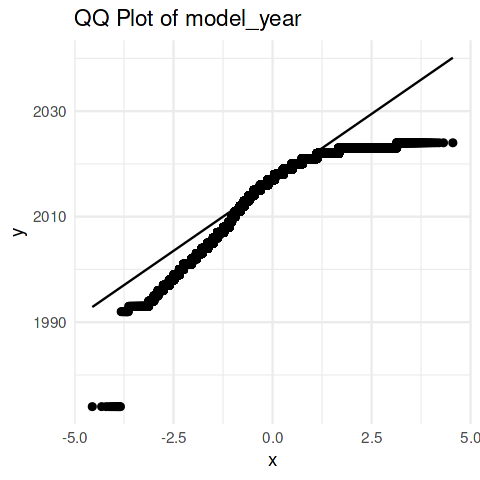

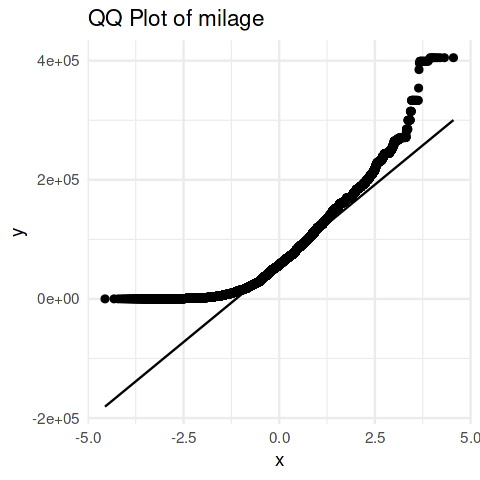

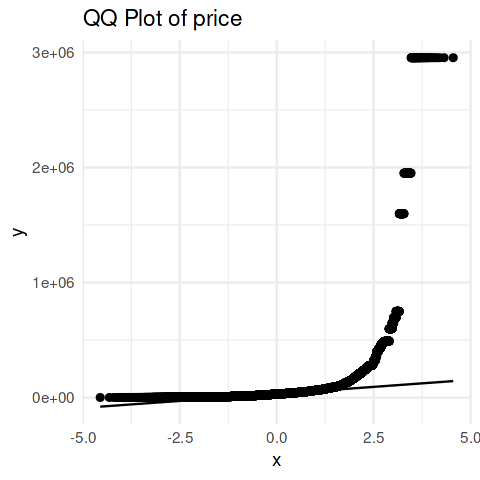

In [7]:
numeric_vars <- names(train)[sapply(train, is.numeric)]

options(
  repr.plot.width = 4,   
  repr.plot.height = 4   
)

for (var in numeric_vars) {
  p <- ggplot(train, aes(sample = .data[[var]])) +
    stat_qq() +
    stat_qq_line() +
    ggtitle(paste("QQ Plot of", var)) +
    theme_minimal()
  
  print(p)
}

**let's take a look at the distribution of each class.**

In [8]:
test$price<-NA
test<-test[,2:13]
bind<-rbind(train,test)

In [9]:
table(bind$brand)


        Acura          Alfa         Aston          Audi       Bentley 
         3849          1149           382         18176          1944 
          BMW       Bugatti         Buick      Cadillac     Chevrolet 
        28314            10          1591          7733         27033 
     Chrysler         Dodge       Ferrari          FIAT          Ford 
         1241          5204           610            81         38353 
      Genesis           GMC         Honda        Hummer       Hyundai 
         1612          5309          3537           862          3353 
     INFINITI        Jaguar          Jeep         Karma           Kia 
         5399          2253         10886            27          4247 
  Lamborghini          Land         Lexus       Lincoln         Lotus 
         1356         15873         14372          4016            71 
        Lucid      Maserati       Maybach         Mazda       McLaren 
          111          1558            10          4489           408 
Merce

In [10]:
#table(bind$model)

In [11]:
#table(bind$transmission)

In [12]:
table(bind$accident)


                                       At least 1 accident or damage reported 
                                  4084                                  69362 
                         None reported 
                                240777 

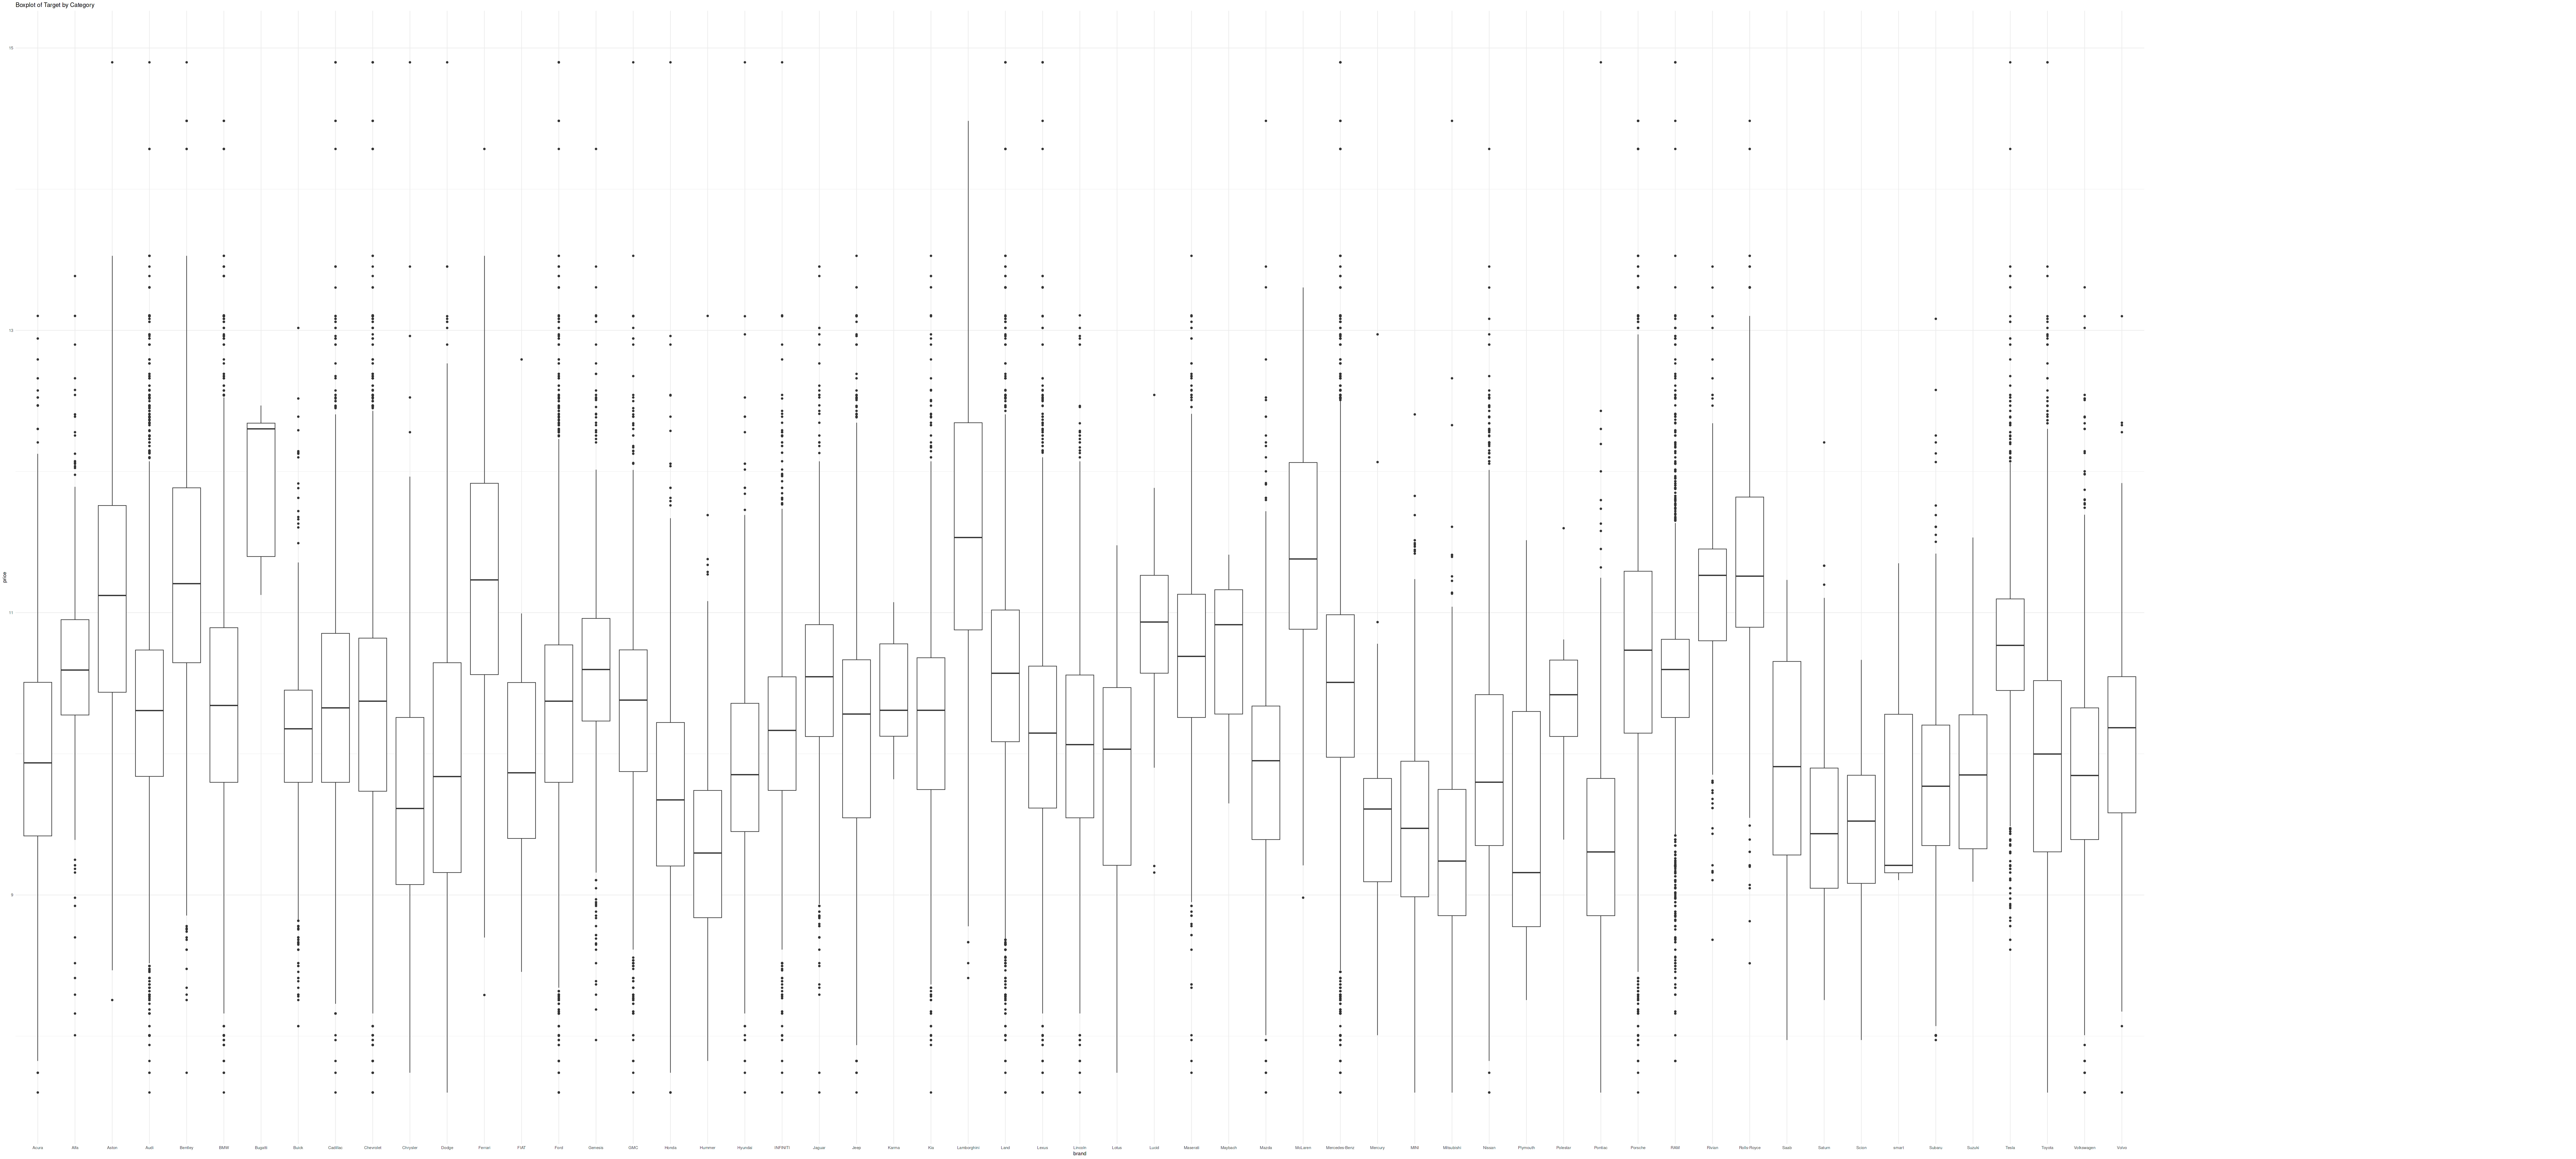

In [13]:
a<-ggplot(train, aes(x = brand, y = log(price))) +
  geom_boxplot() +
  labs(title = "Boxplot of Target by Category",
       x = "brand",
       y = "price") +
  theme_minimal()

options(
  repr.plot.width = 80,   
  repr.plot.height = 36   
)
gridExtra::grid.arrange(a,widths = c(150, 30))

`geom_smooth()` using formula = 'y ~ x'


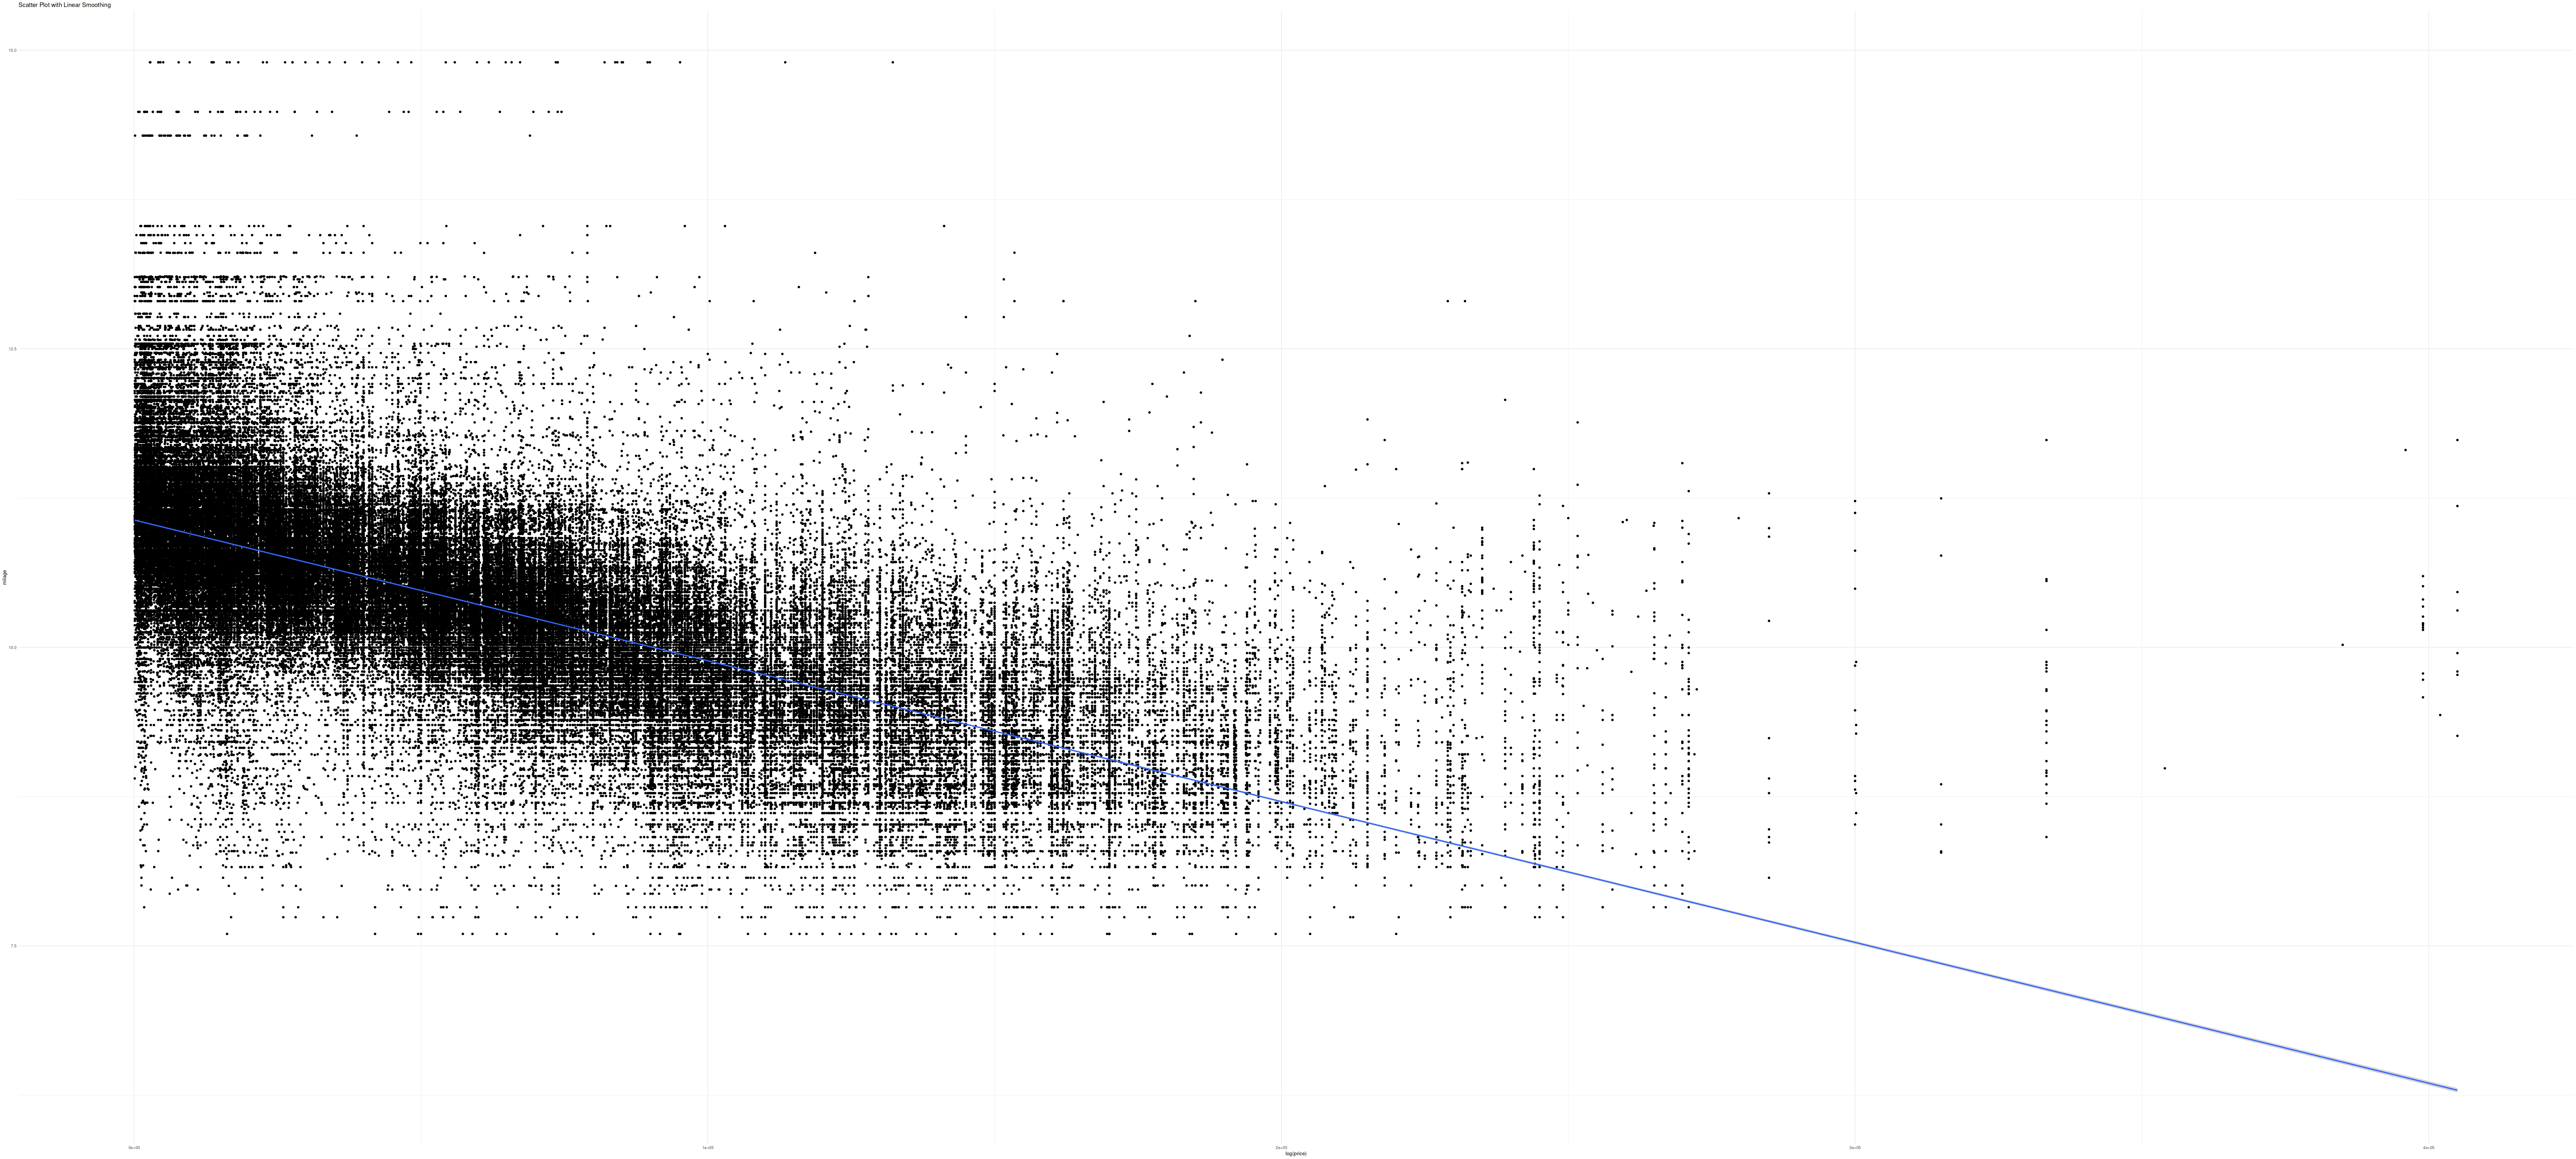

In [14]:
ggplot(train, aes(x = milage, y = log(price))) +  # カンマを削除して閉じ括弧を追加
  geom_point() +
  geom_smooth(method = "lm") +  # 線形回帰線を追加
  labs(title = "Scatter Plot with Linear Smoothing",
       x = "log(price)",
       y = "milage") +
  theme_minimal()

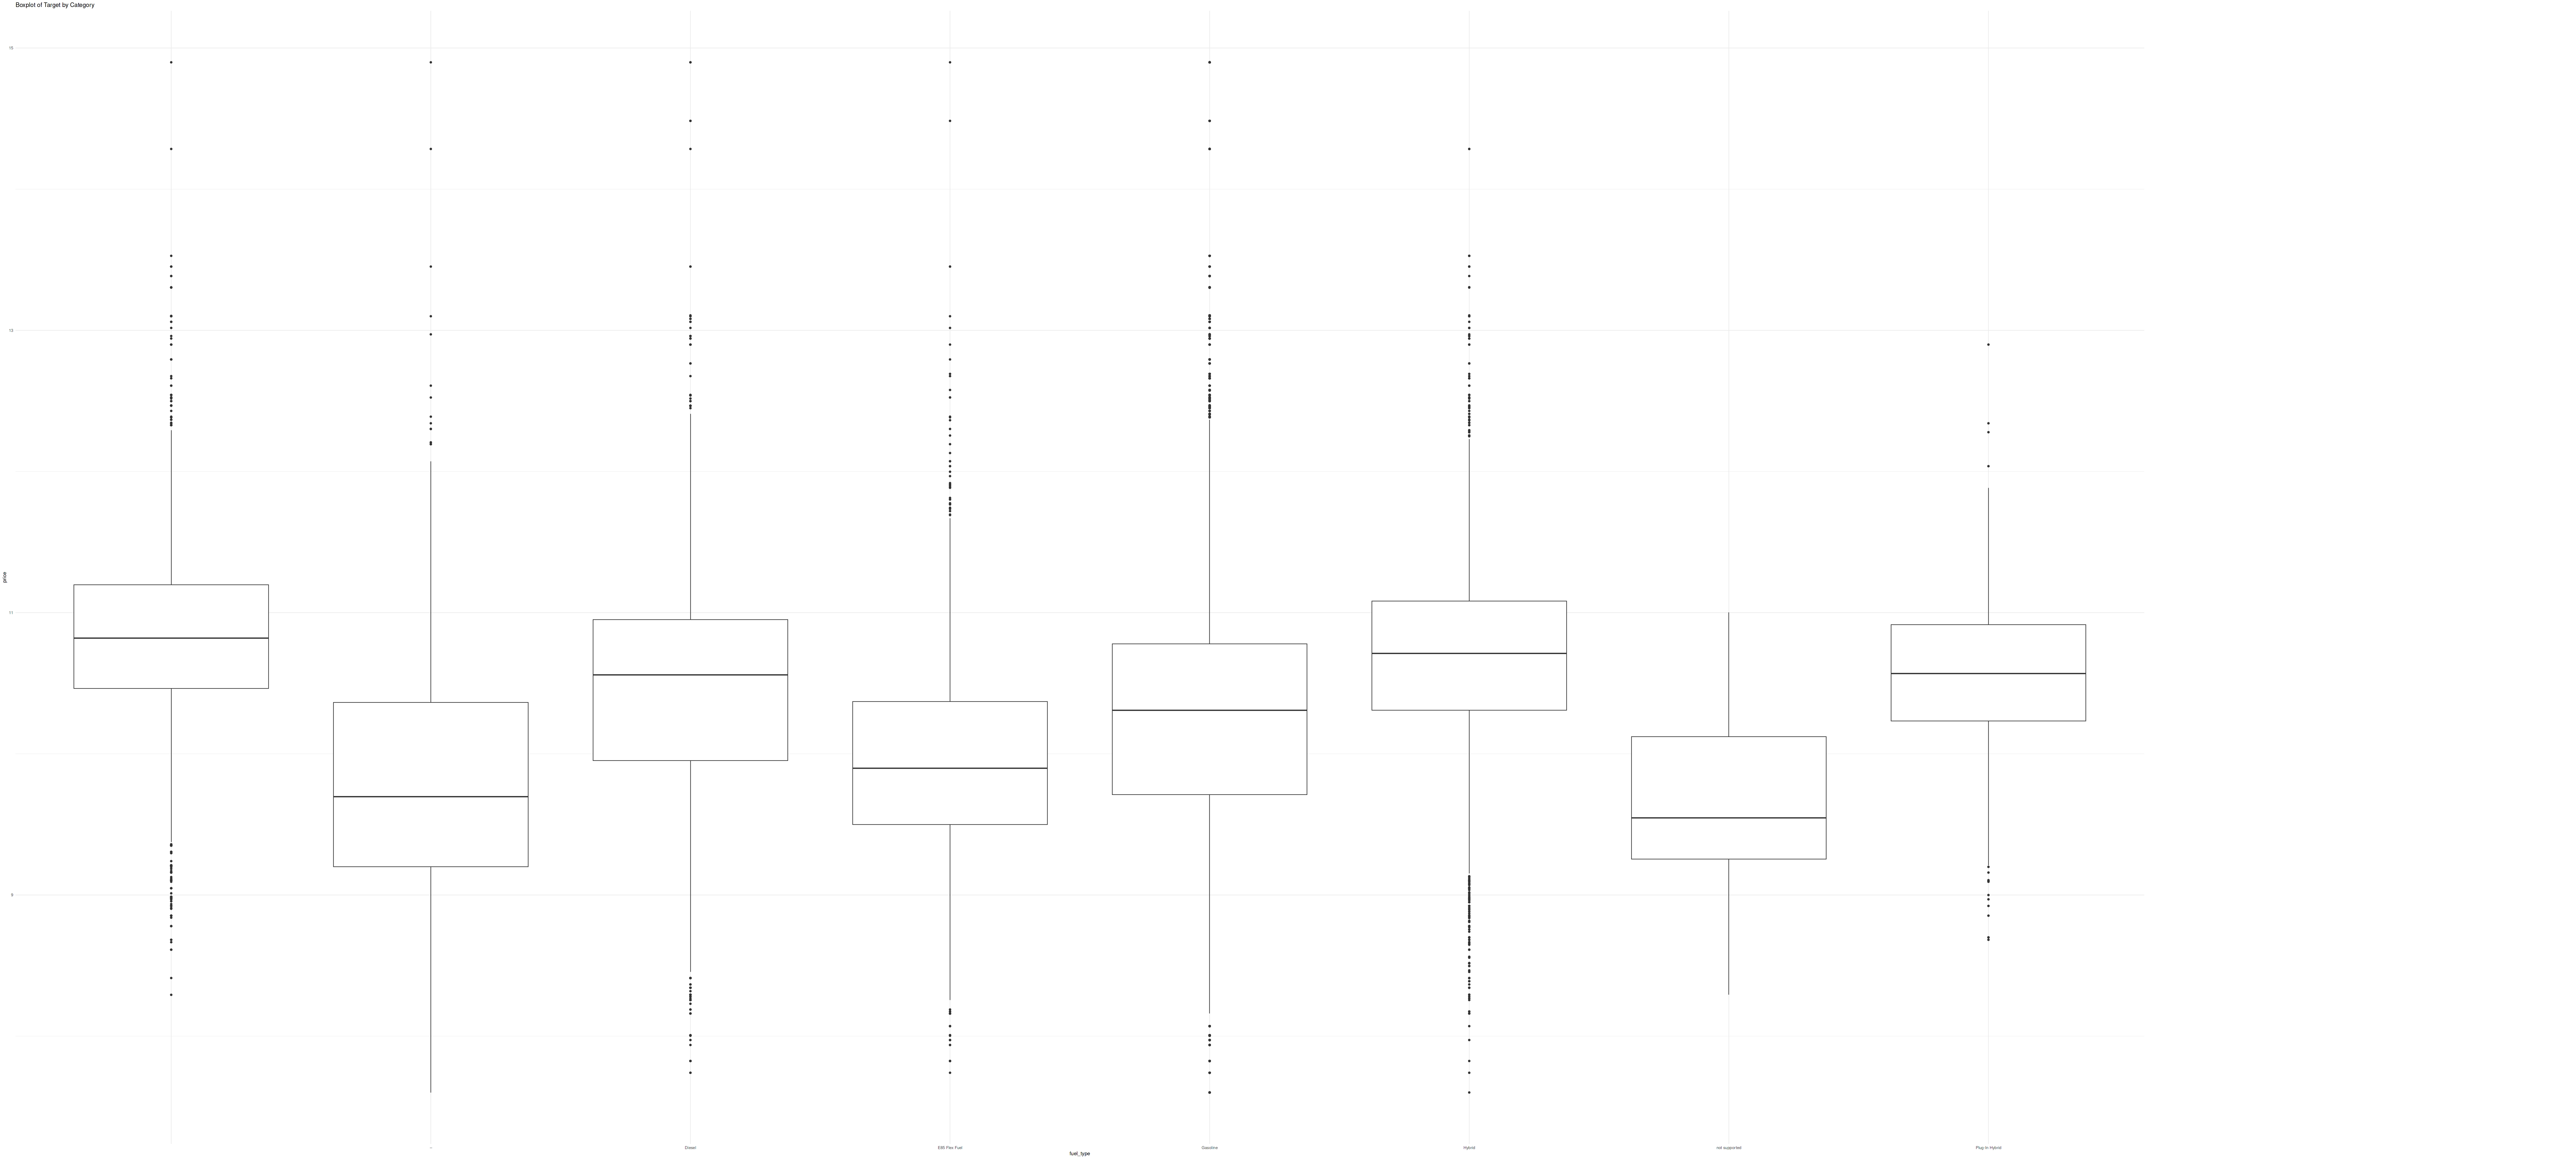

In [15]:
b<-ggplot(train, aes(x = fuel_type, y = log(price))) +
  geom_boxplot() +
  labs(title = "Boxplot of Target by Category",
       x = "fuel_type",
       y = "price") +
  theme_minimal()

options(
  repr.plot.width = 80,   
  repr.plot.height = 36   
)
gridExtra::grid.arrange(b,widths = c(150, 30))

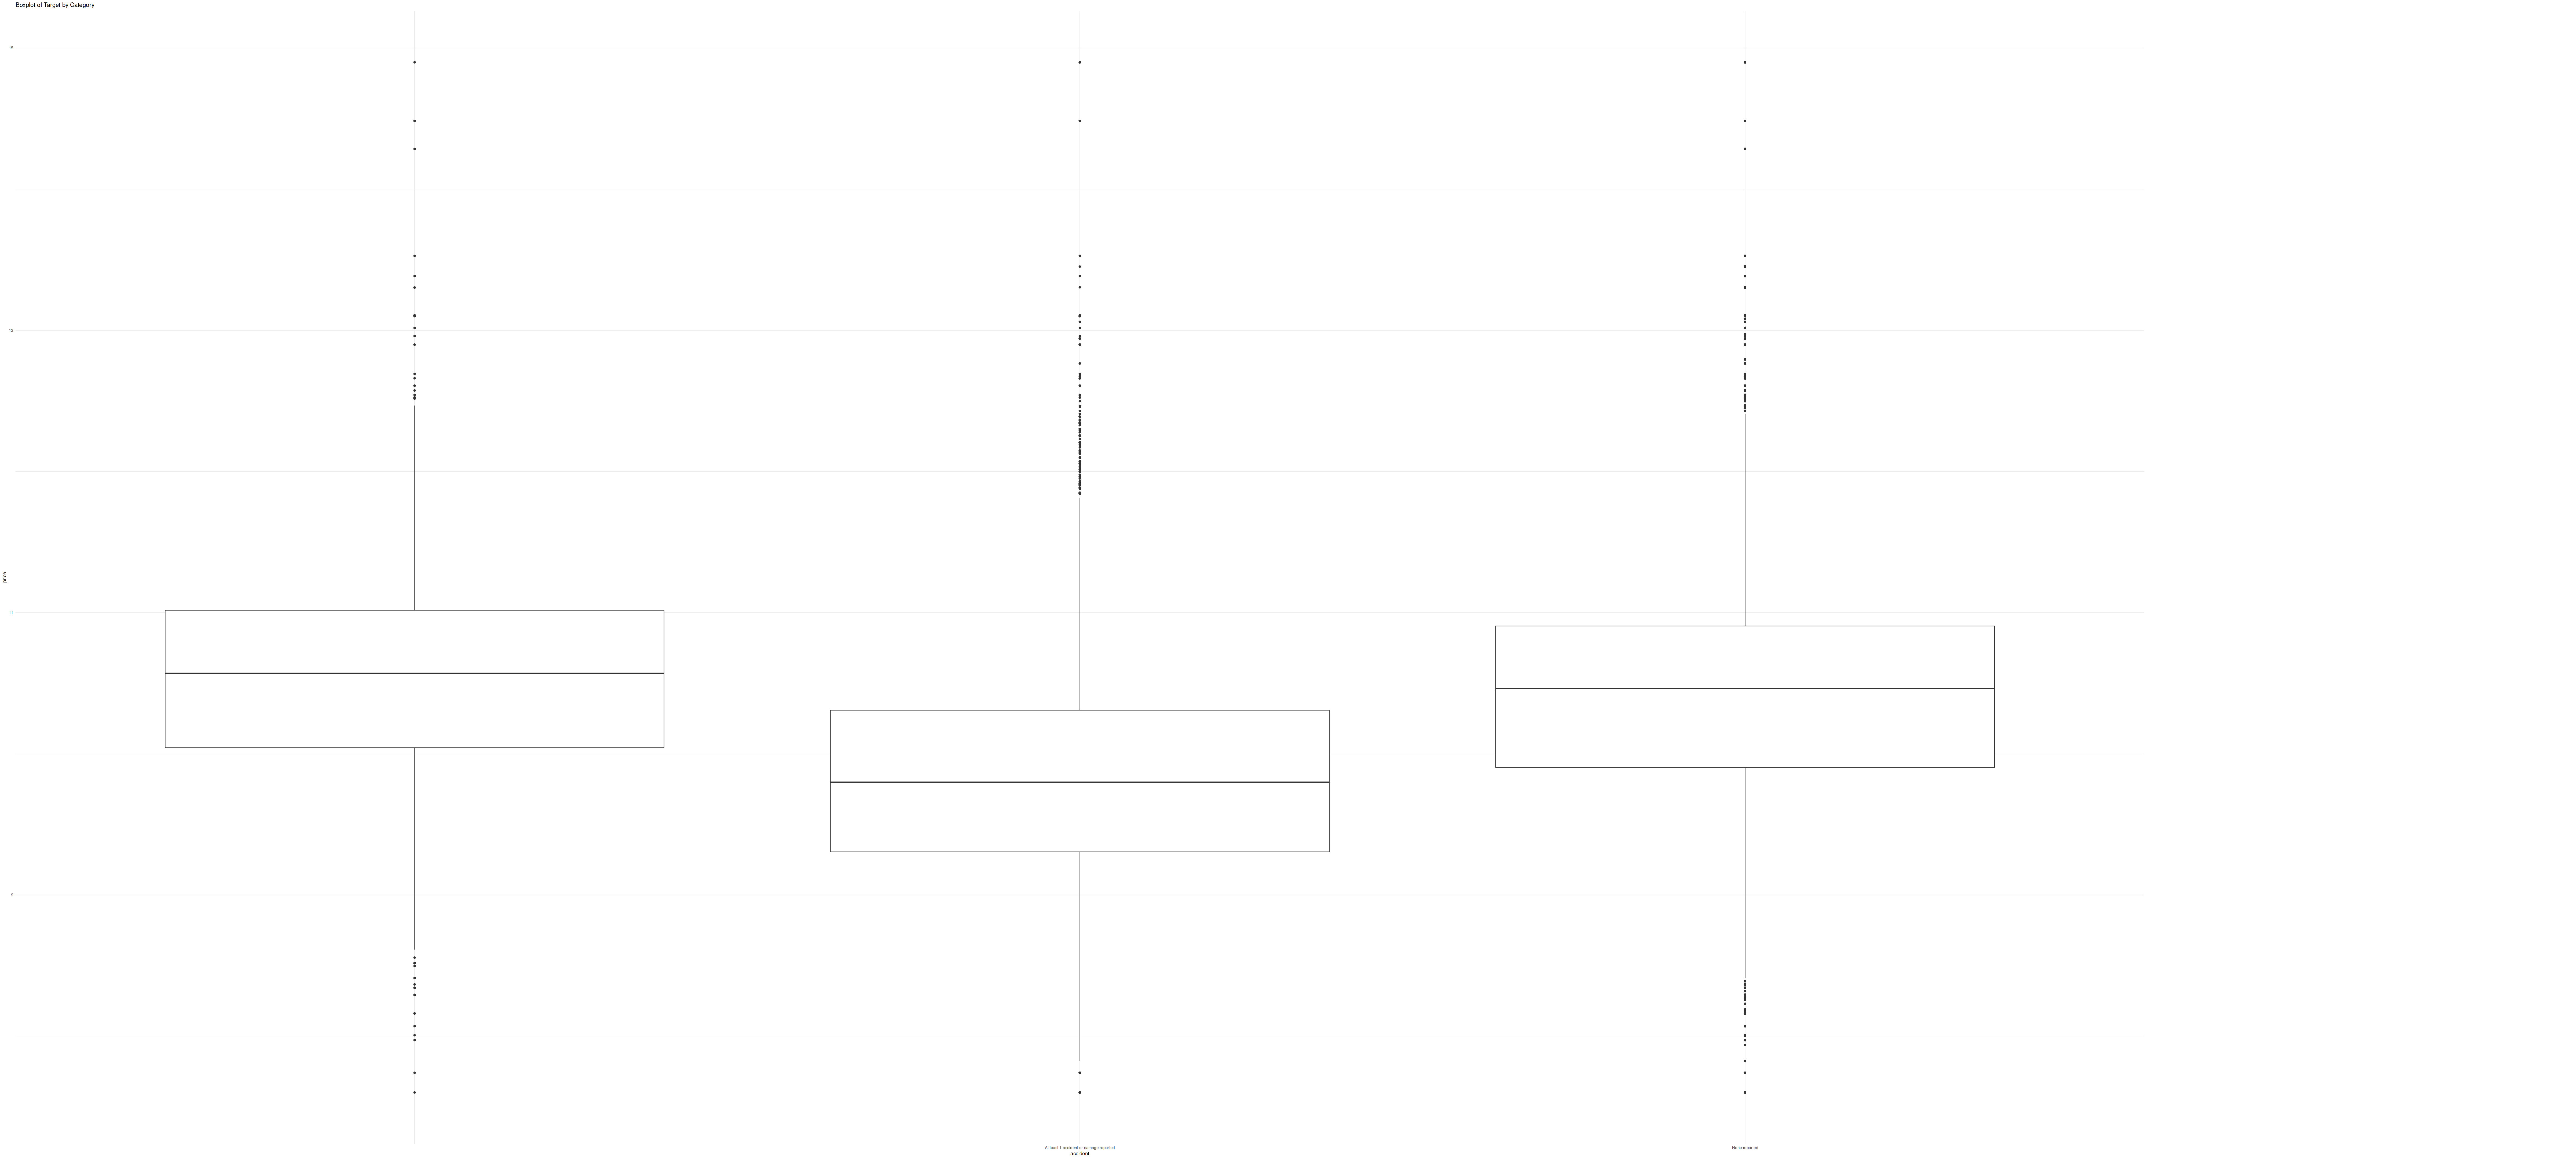

In [16]:
c<-ggplot(train, aes(x = accident, y = log(price))) +
  geom_boxplot() +
  labs(title = "Boxplot of Target by Category",
       x = "accident",
       y = "price") +
  theme_minimal()

options(
  repr.plot.width = 80,   
  repr.plot.height = 36   
)
gridExtra::grid.arrange(c,widths = c(150, 30))

**Create a model**

In [17]:
set.seed(123)

data_split <-
  initial_split(train, strata = price)

train_data <- training(data_split)
test_data  <- testing(data_split)

In [18]:
set.seed(123)

rec <- recipe(price　~ ., data = train_data) %>%
  step_YeoJohnson(all_numeric_predictors())%>%
　step_novel(all_nominal_predictors())%>%
  textrecipes::step_tokenize(model, transmission, ext_col, int_col) %>% 
  textrecipes::step_tokenfilter(model, max_tokens = tune()) %>% 
  textrecipes::step_tfidf(model, transmission, ext_col, int_col) %>%  
  step_zv()

In [19]:
#CAT_spec <-
#  boost_tree() %>%
#    #trees = tune(),
#    #min_n = tune(),
#    #learn_rate = tune(),
#    #tree_depth = tune()
#  set_engine('xgboost',method="catboost",is_unbalance = TRUE,
#             nthread  = future::availableCores())  %>%
#  set_mode(mode = "regression")

In [20]:
#wf =
#  workflow() %>% 
#  add_recipe(rec) %>% 
#  add_model(CAT_spec)

In [21]:
#model =
#  wf %>% 
#  fit(train_data) %>% 
#  with_seed(7, .)

In [22]:
#test_pred = 
#  bind_cols(
#    test_data,
#    predict(model, new_data = test_data, type = "numeric"))%>% 
#  select(price,.pred, everything())

In [23]:
#rmse_result <- test_pred %>%
#  rmse(truth = price, estimate = .pred)

#print(rmse_result)

In [24]:
#model2 =
#  wf %>% 
#  fit(train) %>% 
#  with_seed(7, .)

In [25]:
#CAT <- predict(model2, new_data = test, type = "numeric")

In [26]:
#CATr<-cbind(id,CAT)

In [27]:
#colnames(CATr)<-c("id","price")

In [28]:
#write.csv(CATr,"submission.csv",quote = FALSE, row.names = FALSE)

In [29]:
set.seed(321)

cv_fold <- vfold_cv (train_data, v = 5,
                  repeats = 1, strata = "price")

In [30]:
lgbm_spec <-
  boost_tree(
    trees = tune(),
    tree_depth = tune(),
    learn_rate = tune(),
    mtry = tune(),
    min_n = tune(),
    loss_reduction = tune()
  ) %>%
  set_engine(engine = "lightgbm",
             is_unbalance = TRUE,
             num_leaves = tune(),
             nthread  = future::availableCores()
) %>%
  set_mode(mode = "regression")

In [31]:
wf <- workflow() %>% 
  add_model(lgbm_spec) %>% 
  add_recipe(rec)

In [32]:
lgbm_ctrl <- control_grid(verbose = TRUE,
                        save_pred = FALSE,
                        save_workflow = FALSE)

In [33]:
params <- wf %>%
  extract_parameter_set_dials() %>%
  update(trees = trees(c(300,2200)),
    mtry = mtry(range = c(5,21)),
         min_n = min_n(range = c(5, 50)),
         tree_depth = tree_depth(range = c(3, 50)),
         learn_rate = learn_rate(range = c(-2, -1.5)),
         num_leaves = num_leaves(c(5, 500))) %>%
  finalize(train_data)

In [34]:
set.seed(123)

lgbm_res <- tune_grid(
  wf,
  resamples = cv_fold,
  grid = 60,
  control = lgbm_ctrl,
  metrics = metric_set(rmse),
  param_info = params
)

i Fold1: preprocessor 1/60



✓ Fold1: preprocessor 1/60



i Fold1: preprocessor 1/60, model 1/1



✓ Fold1: preprocessor 1/60, model 1/1



i Fold1: preprocessor 1/60, model 1/1 (extracts)



i Fold1: preprocessor 1/60, model 1/1 (predictions)



i Fold1: preprocessor 2/60



✓ Fold1: preprocessor 2/60



i Fold1: preprocessor 2/60, model 1/1



✓ Fold1: preprocessor 2/60, model 1/1



i Fold1: preprocessor 2/60, model 1/1 (extracts)



i Fold1: preprocessor 2/60, model 1/1 (predictions)



i Fold1: preprocessor 3/60



✓ Fold1: preprocessor 3/60



i Fold1: preprocessor 3/60, model 1/1



✓ Fold1: preprocessor 3/60, model 1/1



i Fold1: preprocessor 3/60, model 1/1 (extracts)



i Fold1: preprocessor 3/60, model 1/1 (predictions)



i Fold1: preprocessor 4/60



✓ Fold1: preprocessor 4/60



i Fold1: preprocessor 4/60, model 1/1



✓ Fold1: preprocessor 4/60, model 1/1



i Fold1: preprocessor 4/60, model 1/1 (extracts)



i Fold1: preprocessor 4/60, model 1/1 (predictions)



i Fold1: preprocessor 5/60



✓ Fold1: preprocessor 5/60



i Fold1: preprocessor 5/60, model 1/1



✓ Fold1: preprocessor 5/60, model 1/1



i Fold1: preprocessor 5/60, model 1/1 (extracts)



i Fold1: preprocessor 5/60, model 1/1 (predictions)



i Fold1: preprocessor 6/60



✓ Fold1: preprocessor 6/60



i Fold1: preprocessor 6/60, model 1/1



✓ Fold1: preprocessor 6/60, model 1/1



i Fold1: preprocessor 6/60, model 1/1 (extracts)



i Fold1: preprocessor 6/60, model 1/1 (predictions)



i Fold1: preprocessor 7/60



✓ Fold1: preprocessor 7/60



i Fold1: preprocessor 7/60, model 1/1



✓ Fold1: preprocessor 7/60, model 1/1



i Fold1: preprocessor 7/60, model 1/1 (extracts)



i Fold1: preprocessor 7/60, model 1/1 (predictions)



i Fold1: preprocessor 8/60



✓ Fold1: preprocessor 8/60



i Fold1: preprocessor 8/60, model 1/1



✓ Fold1: preprocessor 8/60, model 1/1



i Fold1: preprocessor 8/60, model 1/1 (extracts)



i Fold1: preprocessor 8/60, model 1/1 (predictions)



i Fold1: preprocessor 9/60



✓ Fold1: preprocessor 9/60



i Fold1: preprocessor 9/60, model 1/1



✓ Fold1: preprocessor 9/60, model 1/1



i Fold1: preprocessor 9/60, model 1/1 (extracts)



i Fold1: preprocessor 9/60, model 1/1 (predictions)



i Fold1: preprocessor 10/60



✓ Fold1: preprocessor 10/60



i Fold1: preprocessor 10/60, model 1/1



✓ Fold1: preprocessor 10/60, model 1/1



i Fold1: preprocessor 10/60, model 1/1 (extracts)



i Fold1: preprocessor 10/60, model 1/1 (predictions)



i Fold1: preprocessor 11/60



✓ Fold1: preprocessor 11/60



i Fold1: preprocessor 11/60, model 1/1



✓ Fold1: preprocessor 11/60, model 1/1



i Fold1: preprocessor 11/60, model 1/1 (extracts)



i Fold1: preprocessor 11/60, model 1/1 (predictions)



i Fold1: preprocessor 12/60



✓ Fold1: preprocessor 12/60



i Fold1: preprocessor 12/60, model 1/1



✓ Fold1: preprocessor 12/60, model 1/1



i Fold1: preprocessor 12/60, model 1/1 (extracts)



i Fold1: preprocessor 12/60, model 1/1 (predictions)



i Fold1: preprocessor 13/60



✓ Fold1: preprocessor 13/60



i Fold1: preprocessor 13/60, model 1/1



✓ Fold1: preprocessor 13/60, model 1/1



i Fold1: preprocessor 13/60, model 1/1 (extracts)



i Fold1: preprocessor 13/60, model 1/1 (predictions)



i Fold1: preprocessor 14/60



✓ Fold1: preprocessor 14/60



i Fold1: preprocessor 14/60, model 1/1



✓ Fold1: preprocessor 14/60, model 1/1



i Fold1: preprocessor 14/60, model 1/1 (extracts)



i Fold1: preprocessor 14/60, model 1/1 (predictions)



i Fold1: preprocessor 15/60



✓ Fold1: preprocessor 15/60



i Fold1: preprocessor 15/60, model 1/1



✓ Fold1: preprocessor 15/60, model 1/1



i Fold1: preprocessor 15/60, model 1/1 (extracts)



i Fold1: preprocessor 15/60, model 1/1 (predictions)



i Fold1: preprocessor 16/60



✓ Fold1: preprocessor 16/60



i Fold1: preprocessor 16/60, model 1/1



✓ Fold1: preprocessor 16/60, model 1/1



i Fold1: preprocessor 16/60, model 1/1 (extracts)



i Fold1: preprocessor 16/60, model 1/1 (predictions)



i Fold1: preprocessor 17/60



✓ Fold1: preprocessor 17/60



i Fold1: preprocessor 17/60, model 1/1



✓ Fold1: preprocessor 17/60, model 1/1



i Fold1: preprocessor 17/60, model 1/1 (extracts)



i Fold1: preprocessor 17/60, model 1/1 (predictions)



i Fold1: preprocessor 18/60



✓ Fold1: preprocessor 18/60



i Fold1: preprocessor 18/60, model 1/1



✓ Fold1: preprocessor 18/60, model 1/1



i Fold1: preprocessor 18/60, model 1/1 (extracts)



i Fold1: preprocessor 18/60, model 1/1 (predictions)



i Fold1: preprocessor 19/60



✓ Fold1: preprocessor 19/60



i Fold1: preprocessor 19/60, model 1/1



✓ Fold1: preprocessor 19/60, model 1/1



i Fold1: preprocessor 19/60, model 1/1 (extracts)



i Fold1: preprocessor 19/60, model 1/1 (predictions)



i Fold1: preprocessor 20/60



✓ Fold1: preprocessor 20/60



i Fold1: preprocessor 20/60, model 1/1



✓ Fold1: preprocessor 20/60, model 1/1



i Fold1: preprocessor 20/60, model 1/1 (extracts)



i Fold1: preprocessor 20/60, model 1/1 (predictions)



i Fold1: preprocessor 21/60



✓ Fold1: preprocessor 21/60



i Fold1: preprocessor 21/60, model 1/1



✓ Fold1: preprocessor 21/60, model 1/1



i Fold1: preprocessor 21/60, model 1/1 (extracts)



i Fold1: preprocessor 21/60, model 1/1 (predictions)



i Fold1: preprocessor 22/60



✓ Fold1: preprocessor 22/60



i Fold1: preprocessor 22/60, model 1/1



✓ Fold1: preprocessor 22/60, model 1/1



i Fold1: preprocessor 22/60, model 1/1 (extracts)



i Fold1: preprocessor 22/60, model 1/1 (predictions)



i Fold1: preprocessor 23/60



✓ Fold1: preprocessor 23/60



i Fold1: preprocessor 23/60, model 1/1



✓ Fold1: preprocessor 23/60, model 1/1



i Fold1: preprocessor 23/60, model 1/1 (extracts)



i Fold1: preprocessor 23/60, model 1/1 (predictions)



i Fold1: preprocessor 24/60



✓ Fold1: preprocessor 24/60



i Fold1: preprocessor 24/60, model 1/1



✓ Fold1: preprocessor 24/60, model 1/1



i Fold1: preprocessor 24/60, model 1/1 (extracts)



i Fold1: preprocessor 24/60, model 1/1 (predictions)



i Fold1: preprocessor 25/60



✓ Fold1: preprocessor 25/60



i Fold1: preprocessor 25/60, model 1/1



✓ Fold1: preprocessor 25/60, model 1/1



i Fold1: preprocessor 25/60, model 1/1 (extracts)



i Fold1: preprocessor 25/60, model 1/1 (predictions)



i Fold1: preprocessor 26/60



✓ Fold1: preprocessor 26/60



i Fold1: preprocessor 26/60, model 1/1



✓ Fold1: preprocessor 26/60, model 1/1



i Fold1: preprocessor 26/60, model 1/1 (extracts)



i Fold1: preprocessor 26/60, model 1/1 (predictions)



i Fold1: preprocessor 27/60



✓ Fold1: preprocessor 27/60



i Fold1: preprocessor 27/60, model 1/1



✓ Fold1: preprocessor 27/60, model 1/1



i Fold1: preprocessor 27/60, model 1/1 (extracts)



i Fold1: preprocessor 27/60, model 1/1 (predictions)



i Fold1: preprocessor 28/60



✓ Fold1: preprocessor 28/60



i Fold1: preprocessor 28/60, model 1/1



✓ Fold1: preprocessor 28/60, model 1/1



i Fold1: preprocessor 28/60, model 1/1 (extracts)



i Fold1: preprocessor 28/60, model 1/1 (predictions)



i Fold1: preprocessor 29/60



✓ Fold1: preprocessor 29/60



i Fold1: preprocessor 29/60, model 1/1



✓ Fold1: preprocessor 29/60, model 1/1



i Fold1: preprocessor 29/60, model 1/1 (extracts)



i Fold1: preprocessor 29/60, model 1/1 (predictions)



i Fold1: preprocessor 30/60



✓ Fold1: preprocessor 30/60



i Fold1: preprocessor 30/60, model 1/1



✓ Fold1: preprocessor 30/60, model 1/1



i Fold1: preprocessor 30/60, model 1/1 (extracts)



i Fold1: preprocessor 30/60, model 1/1 (predictions)



i Fold1: preprocessor 31/60



✓ Fold1: preprocessor 31/60



i Fold1: preprocessor 31/60, model 1/1



✓ Fold1: preprocessor 31/60, model 1/1



i Fold1: preprocessor 31/60, model 1/1 (extracts)



i Fold1: preprocessor 31/60, model 1/1 (predictions)



i Fold1: preprocessor 32/60



✓ Fold1: preprocessor 32/60



i Fold1: preprocessor 32/60, model 1/1



✓ Fold1: preprocessor 32/60, model 1/1



i Fold1: preprocessor 32/60, model 1/1 (extracts)



i Fold1: preprocessor 32/60, model 1/1 (predictions)



i Fold1: preprocessor 33/60



✓ Fold1: preprocessor 33/60



i Fold1: preprocessor 33/60, model 1/1



✓ Fold1: preprocessor 33/60, model 1/1



i Fold1: preprocessor 33/60, model 1/1 (extracts)



i Fold1: preprocessor 33/60, model 1/1 (predictions)



i Fold1: preprocessor 34/60



✓ Fold1: preprocessor 34/60



i Fold1: preprocessor 34/60, model 1/1



✓ Fold1: preprocessor 34/60, model 1/1



i Fold1: preprocessor 34/60, model 1/1 (extracts)



i Fold1: preprocessor 34/60, model 1/1 (predictions)



i Fold1: preprocessor 35/60



✓ Fold1: preprocessor 35/60



i Fold1: preprocessor 35/60, model 1/1



✓ Fold1: preprocessor 35/60, model 1/1



i Fold1: preprocessor 35/60, model 1/1 (extracts)



i Fold1: preprocessor 35/60, model 1/1 (predictions)



i Fold1: preprocessor 36/60



✓ Fold1: preprocessor 36/60



i Fold1: preprocessor 36/60, model 1/1



✓ Fold1: preprocessor 36/60, model 1/1



i Fold1: preprocessor 36/60, model 1/1 (extracts)



i Fold1: preprocessor 36/60, model 1/1 (predictions)



i Fold1: preprocessor 37/60



✓ Fold1: preprocessor 37/60



i Fold1: preprocessor 37/60, model 1/1



✓ Fold1: preprocessor 37/60, model 1/1



i Fold1: preprocessor 37/60, model 1/1 (extracts)



i Fold1: preprocessor 37/60, model 1/1 (predictions)



i Fold1: preprocessor 38/60



✓ Fold1: preprocessor 38/60



i Fold1: preprocessor 38/60, model 1/1



✓ Fold1: preprocessor 38/60, model 1/1



i Fold1: preprocessor 38/60, model 1/1 (extracts)



i Fold1: preprocessor 38/60, model 1/1 (predictions)



i Fold1: preprocessor 39/60



✓ Fold1: preprocessor 39/60



i Fold1: preprocessor 39/60, model 1/1



✓ Fold1: preprocessor 39/60, model 1/1



i Fold1: preprocessor 39/60, model 1/1 (extracts)



i Fold1: preprocessor 39/60, model 1/1 (predictions)



i Fold1: preprocessor 40/60



✓ Fold1: preprocessor 40/60



i Fold1: preprocessor 40/60, model 1/1



✓ Fold1: preprocessor 40/60, model 1/1



i Fold1: preprocessor 40/60, model 1/1 (extracts)



i Fold1: preprocessor 40/60, model 1/1 (predictions)



i Fold1: preprocessor 41/60



✓ Fold1: preprocessor 41/60



i Fold1: preprocessor 41/60, model 1/1



✓ Fold1: preprocessor 41/60, model 1/1



i Fold1: preprocessor 41/60, model 1/1 (extracts)



i Fold1: preprocessor 41/60, model 1/1 (predictions)



i Fold1: preprocessor 42/60



✓ Fold1: preprocessor 42/60



i Fold1: preprocessor 42/60, model 1/1



✓ Fold1: preprocessor 42/60, model 1/1



i Fold1: preprocessor 42/60, model 1/1 (extracts)



i Fold1: preprocessor 42/60, model 1/1 (predictions)



i Fold1: preprocessor 43/60



✓ Fold1: preprocessor 43/60



i Fold1: preprocessor 43/60, model 1/1



✓ Fold1: preprocessor 43/60, model 1/1



i Fold1: preprocessor 43/60, model 1/1 (extracts)



i Fold1: preprocessor 43/60, model 1/1 (predictions)



i Fold1: preprocessor 44/60



✓ Fold1: preprocessor 44/60



i Fold1: preprocessor 44/60, model 1/1



✓ Fold1: preprocessor 44/60, model 1/1



i Fold1: preprocessor 44/60, model 1/1 (extracts)



i Fold1: preprocessor 44/60, model 1/1 (predictions)



i Fold1: preprocessor 45/60



✓ Fold1: preprocessor 45/60



i Fold1: preprocessor 45/60, model 1/1



✓ Fold1: preprocessor 45/60, model 1/1



i Fold1: preprocessor 45/60, model 1/1 (extracts)



i Fold1: preprocessor 45/60, model 1/1 (predictions)



i Fold1: preprocessor 46/60



✓ Fold1: preprocessor 46/60



i Fold1: preprocessor 46/60, model 1/1



✓ Fold1: preprocessor 46/60, model 1/1



i Fold1: preprocessor 46/60, model 1/1 (extracts)



i Fold1: preprocessor 46/60, model 1/1 (predictions)



i Fold1: preprocessor 47/60



✓ Fold1: preprocessor 47/60



i Fold1: preprocessor 47/60, model 1/1



✓ Fold1: preprocessor 47/60, model 1/1



i Fold1: preprocessor 47/60, model 1/1 (extracts)



i Fold1: preprocessor 47/60, model 1/1 (predictions)



i Fold1: preprocessor 48/60



✓ Fold1: preprocessor 48/60



i Fold1: preprocessor 48/60, model 1/1



✓ Fold1: preprocessor 48/60, model 1/1



i Fold1: preprocessor 48/60, model 1/1 (extracts)



i Fold1: preprocessor 48/60, model 1/1 (predictions)



i Fold1: preprocessor 49/60



✓ Fold1: preprocessor 49/60



i Fold1: preprocessor 49/60, model 1/1



✓ Fold1: preprocessor 49/60, model 1/1



i Fold1: preprocessor 49/60, model 1/1 (extracts)



i Fold1: preprocessor 49/60, model 1/1 (predictions)



i Fold1: preprocessor 50/60



✓ Fold1: preprocessor 50/60



i Fold1: preprocessor 50/60, model 1/1



✓ Fold1: preprocessor 50/60, model 1/1



i Fold1: preprocessor 50/60, model 1/1 (extracts)



i Fold1: preprocessor 50/60, model 1/1 (predictions)



i Fold1: preprocessor 51/60



✓ Fold1: preprocessor 51/60



i Fold1: preprocessor 51/60, model 1/1



✓ Fold1: preprocessor 51/60, model 1/1



i Fold1: preprocessor 51/60, model 1/1 (extracts)



i Fold1: preprocessor 51/60, model 1/1 (predictions)



i Fold1: preprocessor 52/60



✓ Fold1: preprocessor 52/60



i Fold1: preprocessor 52/60, model 1/1



✓ Fold1: preprocessor 52/60, model 1/1



i Fold1: preprocessor 52/60, model 1/1 (extracts)



i Fold1: preprocessor 52/60, model 1/1 (predictions)



i Fold1: preprocessor 53/60



✓ Fold1: preprocessor 53/60



i Fold1: preprocessor 53/60, model 1/1



✓ Fold1: preprocessor 53/60, model 1/1



i Fold1: preprocessor 53/60, model 1/1 (extracts)



i Fold1: preprocessor 53/60, model 1/1 (predictions)



i Fold1: preprocessor 54/60



✓ Fold1: preprocessor 54/60



i Fold1: preprocessor 54/60, model 1/1



✓ Fold1: preprocessor 54/60, model 1/1



i Fold1: preprocessor 54/60, model 1/1 (extracts)



i Fold1: preprocessor 54/60, model 1/1 (predictions)



i Fold1: preprocessor 55/60



✓ Fold1: preprocessor 55/60



i Fold1: preprocessor 55/60, model 1/1



✓ Fold1: preprocessor 55/60, model 1/1



i Fold1: preprocessor 55/60, model 1/1 (extracts)



i Fold1: preprocessor 55/60, model 1/1 (predictions)



i Fold1: preprocessor 56/60



✓ Fold1: preprocessor 56/60



i Fold1: preprocessor 56/60, model 1/1



✓ Fold1: preprocessor 56/60, model 1/1



i Fold1: preprocessor 56/60, model 1/1 (extracts)



i Fold1: preprocessor 56/60, model 1/1 (predictions)



i Fold1: preprocessor 57/60



✓ Fold1: preprocessor 57/60



i Fold1: preprocessor 57/60, model 1/1



✓ Fold1: preprocessor 57/60, model 1/1



i Fold1: preprocessor 57/60, model 1/1 (extracts)



i Fold1: preprocessor 57/60, model 1/1 (predictions)



i Fold1: preprocessor 58/60



✓ Fold1: preprocessor 58/60



i Fold1: preprocessor 58/60, model 1/1



✓ Fold1: preprocessor 58/60, model 1/1



i Fold1: preprocessor 58/60, model 1/1 (extracts)



i Fold1: preprocessor 58/60, model 1/1 (predictions)



i Fold1: preprocessor 59/60



✓ Fold1: preprocessor 59/60



i Fold1: preprocessor 59/60, model 1/1



✓ Fold1: preprocessor 59/60, model 1/1



i Fold1: preprocessor 59/60, model 1/1 (extracts)



i Fold1: preprocessor 59/60, model 1/1 (predictions)



i Fold1: preprocessor 60/60



✓ Fold1: preprocessor 60/60



i Fold1: preprocessor 60/60, model 1/1



✓ Fold1: preprocessor 60/60, model 1/1



i Fold1: preprocessor 60/60, model 1/1 (extracts)



i Fold1: preprocessor 60/60, model 1/1 (predictions)



i Fold2: preprocessor 1/60



✓ Fold2: preprocessor 1/60



i Fold2: preprocessor 1/60, model 1/1



✓ Fold2: preprocessor 1/60, model 1/1



i Fold2: preprocessor 1/60, model 1/1 (extracts)



i Fold2: preprocessor 1/60, model 1/1 (predictions)



i Fold2: preprocessor 2/60



✓ Fold2: preprocessor 2/60



i Fold2: preprocessor 2/60, model 1/1



✓ Fold2: preprocessor 2/60, model 1/1



i Fold2: preprocessor 2/60, model 1/1 (extracts)



i Fold2: preprocessor 2/60, model 1/1 (predictions)



i Fold2: preprocessor 3/60



✓ Fold2: preprocessor 3/60



i Fold2: preprocessor 3/60, model 1/1



✓ Fold2: preprocessor 3/60, model 1/1



i Fold2: preprocessor 3/60, model 1/1 (extracts)



i Fold2: preprocessor 3/60, model 1/1 (predictions)



i Fold2: preprocessor 4/60



✓ Fold2: preprocessor 4/60



i Fold2: preprocessor 4/60, model 1/1



✓ Fold2: preprocessor 4/60, model 1/1



i Fold2: preprocessor 4/60, model 1/1 (extracts)



i Fold2: preprocessor 4/60, model 1/1 (predictions)



i Fold2: preprocessor 5/60



✓ Fold2: preprocessor 5/60



i Fold2: preprocessor 5/60, model 1/1



✓ Fold2: preprocessor 5/60, model 1/1



i Fold2: preprocessor 5/60, model 1/1 (extracts)



i Fold2: preprocessor 5/60, model 1/1 (predictions)



i Fold2: preprocessor 6/60



✓ Fold2: preprocessor 6/60



i Fold2: preprocessor 6/60, model 1/1



✓ Fold2: preprocessor 6/60, model 1/1



i Fold2: preprocessor 6/60, model 1/1 (extracts)



i Fold2: preprocessor 6/60, model 1/1 (predictions)



i Fold2: preprocessor 7/60



✓ Fold2: preprocessor 7/60



i Fold2: preprocessor 7/60, model 1/1



✓ Fold2: preprocessor 7/60, model 1/1



i Fold2: preprocessor 7/60, model 1/1 (extracts)



i Fold2: preprocessor 7/60, model 1/1 (predictions)



i Fold2: preprocessor 8/60



✓ Fold2: preprocessor 8/60



i Fold2: preprocessor 8/60, model 1/1



✓ Fold2: preprocessor 8/60, model 1/1



i Fold2: preprocessor 8/60, model 1/1 (extracts)



i Fold2: preprocessor 8/60, model 1/1 (predictions)



i Fold2: preprocessor 9/60



✓ Fold2: preprocessor 9/60



i Fold2: preprocessor 9/60, model 1/1



✓ Fold2: preprocessor 9/60, model 1/1



i Fold2: preprocessor 9/60, model 1/1 (extracts)



i Fold2: preprocessor 9/60, model 1/1 (predictions)



i Fold2: preprocessor 10/60



✓ Fold2: preprocessor 10/60



i Fold2: preprocessor 10/60, model 1/1



✓ Fold2: preprocessor 10/60, model 1/1



i Fold2: preprocessor 10/60, model 1/1 (extracts)



i Fold2: preprocessor 10/60, model 1/1 (predictions)



i Fold2: preprocessor 11/60



✓ Fold2: preprocessor 11/60



i Fold2: preprocessor 11/60, model 1/1



✓ Fold2: preprocessor 11/60, model 1/1



i Fold2: preprocessor 11/60, model 1/1 (extracts)



i Fold2: preprocessor 11/60, model 1/1 (predictions)



i Fold2: preprocessor 12/60



✓ Fold2: preprocessor 12/60



i Fold2: preprocessor 12/60, model 1/1



✓ Fold2: preprocessor 12/60, model 1/1



i Fold2: preprocessor 12/60, model 1/1 (extracts)



i Fold2: preprocessor 12/60, model 1/1 (predictions)



i Fold2: preprocessor 13/60



✓ Fold2: preprocessor 13/60



i Fold2: preprocessor 13/60, model 1/1



✓ Fold2: preprocessor 13/60, model 1/1



i Fold2: preprocessor 13/60, model 1/1 (extracts)



i Fold2: preprocessor 13/60, model 1/1 (predictions)



i Fold2: preprocessor 14/60



✓ Fold2: preprocessor 14/60



i Fold2: preprocessor 14/60, model 1/1



✓ Fold2: preprocessor 14/60, model 1/1



i Fold2: preprocessor 14/60, model 1/1 (extracts)



i Fold2: preprocessor 14/60, model 1/1 (predictions)



i Fold2: preprocessor 15/60



✓ Fold2: preprocessor 15/60



i Fold2: preprocessor 15/60, model 1/1



✓ Fold2: preprocessor 15/60, model 1/1



i Fold2: preprocessor 15/60, model 1/1 (extracts)



i Fold2: preprocessor 15/60, model 1/1 (predictions)



i Fold2: preprocessor 16/60



✓ Fold2: preprocessor 16/60



i Fold2: preprocessor 16/60, model 1/1



✓ Fold2: preprocessor 16/60, model 1/1



i Fold2: preprocessor 16/60, model 1/1 (extracts)



i Fold2: preprocessor 16/60, model 1/1 (predictions)



i Fold2: preprocessor 17/60



✓ Fold2: preprocessor 17/60



i Fold2: preprocessor 17/60, model 1/1



✓ Fold2: preprocessor 17/60, model 1/1



i Fold2: preprocessor 17/60, model 1/1 (extracts)



i Fold2: preprocessor 17/60, model 1/1 (predictions)



i Fold2: preprocessor 18/60



✓ Fold2: preprocessor 18/60



i Fold2: preprocessor 18/60, model 1/1



✓ Fold2: preprocessor 18/60, model 1/1



i Fold2: preprocessor 18/60, model 1/1 (extracts)



i Fold2: preprocessor 18/60, model 1/1 (predictions)



i Fold2: preprocessor 19/60



✓ Fold2: preprocessor 19/60



i Fold2: preprocessor 19/60, model 1/1



✓ Fold2: preprocessor 19/60, model 1/1



i Fold2: preprocessor 19/60, model 1/1 (extracts)



i Fold2: preprocessor 19/60, model 1/1 (predictions)



i Fold2: preprocessor 20/60



✓ Fold2: preprocessor 20/60



i Fold2: preprocessor 20/60, model 1/1



✓ Fold2: preprocessor 20/60, model 1/1



i Fold2: preprocessor 20/60, model 1/1 (extracts)



i Fold2: preprocessor 20/60, model 1/1 (predictions)



i Fold2: preprocessor 21/60



✓ Fold2: preprocessor 21/60



i Fold2: preprocessor 21/60, model 1/1



✓ Fold2: preprocessor 21/60, model 1/1



i Fold2: preprocessor 21/60, model 1/1 (extracts)



i Fold2: preprocessor 21/60, model 1/1 (predictions)



i Fold2: preprocessor 22/60



✓ Fold2: preprocessor 22/60



i Fold2: preprocessor 22/60, model 1/1



✓ Fold2: preprocessor 22/60, model 1/1



i Fold2: preprocessor 22/60, model 1/1 (extracts)



i Fold2: preprocessor 22/60, model 1/1 (predictions)



i Fold2: preprocessor 23/60



✓ Fold2: preprocessor 23/60



i Fold2: preprocessor 23/60, model 1/1



✓ Fold2: preprocessor 23/60, model 1/1



i Fold2: preprocessor 23/60, model 1/1 (extracts)



i Fold2: preprocessor 23/60, model 1/1 (predictions)



i Fold2: preprocessor 24/60



✓ Fold2: preprocessor 24/60



i Fold2: preprocessor 24/60, model 1/1



✓ Fold2: preprocessor 24/60, model 1/1



i Fold2: preprocessor 24/60, model 1/1 (extracts)



i Fold2: preprocessor 24/60, model 1/1 (predictions)



i Fold2: preprocessor 25/60



✓ Fold2: preprocessor 25/60



i Fold2: preprocessor 25/60, model 1/1



✓ Fold2: preprocessor 25/60, model 1/1



i Fold2: preprocessor 25/60, model 1/1 (extracts)



i Fold2: preprocessor 25/60, model 1/1 (predictions)



i Fold2: preprocessor 26/60



✓ Fold2: preprocessor 26/60



i Fold2: preprocessor 26/60, model 1/1



✓ Fold2: preprocessor 26/60, model 1/1



i Fold2: preprocessor 26/60, model 1/1 (extracts)



i Fold2: preprocessor 26/60, model 1/1 (predictions)



i Fold2: preprocessor 27/60



✓ Fold2: preprocessor 27/60



i Fold2: preprocessor 27/60, model 1/1



✓ Fold2: preprocessor 27/60, model 1/1



i Fold2: preprocessor 27/60, model 1/1 (extracts)



i Fold2: preprocessor 27/60, model 1/1 (predictions)



i Fold2: preprocessor 28/60



✓ Fold2: preprocessor 28/60



i Fold2: preprocessor 28/60, model 1/1



✓ Fold2: preprocessor 28/60, model 1/1



i Fold2: preprocessor 28/60, model 1/1 (extracts)



i Fold2: preprocessor 28/60, model 1/1 (predictions)



i Fold2: preprocessor 29/60



✓ Fold2: preprocessor 29/60



i Fold2: preprocessor 29/60, model 1/1



✓ Fold2: preprocessor 29/60, model 1/1



i Fold2: preprocessor 29/60, model 1/1 (extracts)



i Fold2: preprocessor 29/60, model 1/1 (predictions)



i Fold2: preprocessor 30/60



✓ Fold2: preprocessor 30/60



i Fold2: preprocessor 30/60, model 1/1



✓ Fold2: preprocessor 30/60, model 1/1



i Fold2: preprocessor 30/60, model 1/1 (extracts)



i Fold2: preprocessor 30/60, model 1/1 (predictions)



i Fold2: preprocessor 31/60



✓ Fold2: preprocessor 31/60



i Fold2: preprocessor 31/60, model 1/1



✓ Fold2: preprocessor 31/60, model 1/1



i Fold2: preprocessor 31/60, model 1/1 (extracts)



i Fold2: preprocessor 31/60, model 1/1 (predictions)



i Fold2: preprocessor 32/60



✓ Fold2: preprocessor 32/60



i Fold2: preprocessor 32/60, model 1/1



✓ Fold2: preprocessor 32/60, model 1/1



i Fold2: preprocessor 32/60, model 1/1 (extracts)



i Fold2: preprocessor 32/60, model 1/1 (predictions)



i Fold2: preprocessor 33/60



✓ Fold2: preprocessor 33/60



i Fold2: preprocessor 33/60, model 1/1



✓ Fold2: preprocessor 33/60, model 1/1



i Fold2: preprocessor 33/60, model 1/1 (extracts)



i Fold2: preprocessor 33/60, model 1/1 (predictions)



i Fold2: preprocessor 34/60



✓ Fold2: preprocessor 34/60



i Fold2: preprocessor 34/60, model 1/1



✓ Fold2: preprocessor 34/60, model 1/1



i Fold2: preprocessor 34/60, model 1/1 (extracts)



i Fold2: preprocessor 34/60, model 1/1 (predictions)



i Fold2: preprocessor 35/60



✓ Fold2: preprocessor 35/60



i Fold2: preprocessor 35/60, model 1/1



✓ Fold2: preprocessor 35/60, model 1/1



i Fold2: preprocessor 35/60, model 1/1 (extracts)



i Fold2: preprocessor 35/60, model 1/1 (predictions)



i Fold2: preprocessor 36/60



✓ Fold2: preprocessor 36/60



i Fold2: preprocessor 36/60, model 1/1



✓ Fold2: preprocessor 36/60, model 1/1



i Fold2: preprocessor 36/60, model 1/1 (extracts)



i Fold2: preprocessor 36/60, model 1/1 (predictions)



i Fold2: preprocessor 37/60



✓ Fold2: preprocessor 37/60



i Fold2: preprocessor 37/60, model 1/1



✓ Fold2: preprocessor 37/60, model 1/1



i Fold2: preprocessor 37/60, model 1/1 (extracts)



i Fold2: preprocessor 37/60, model 1/1 (predictions)



i Fold2: preprocessor 38/60



✓ Fold2: preprocessor 38/60



i Fold2: preprocessor 38/60, model 1/1



✓ Fold2: preprocessor 38/60, model 1/1



i Fold2: preprocessor 38/60, model 1/1 (extracts)



i Fold2: preprocessor 38/60, model 1/1 (predictions)



i Fold2: preprocessor 39/60



✓ Fold2: preprocessor 39/60



i Fold2: preprocessor 39/60, model 1/1



✓ Fold2: preprocessor 39/60, model 1/1



i Fold2: preprocessor 39/60, model 1/1 (extracts)



i Fold2: preprocessor 39/60, model 1/1 (predictions)



i Fold2: preprocessor 40/60



✓ Fold2: preprocessor 40/60



i Fold2: preprocessor 40/60, model 1/1



✓ Fold2: preprocessor 40/60, model 1/1



i Fold2: preprocessor 40/60, model 1/1 (extracts)



i Fold2: preprocessor 40/60, model 1/1 (predictions)



i Fold2: preprocessor 41/60



✓ Fold2: preprocessor 41/60



i Fold2: preprocessor 41/60, model 1/1



✓ Fold2: preprocessor 41/60, model 1/1



i Fold2: preprocessor 41/60, model 1/1 (extracts)



i Fold2: preprocessor 41/60, model 1/1 (predictions)



i Fold2: preprocessor 42/60



✓ Fold2: preprocessor 42/60



i Fold2: preprocessor 42/60, model 1/1



✓ Fold2: preprocessor 42/60, model 1/1



i Fold2: preprocessor 42/60, model 1/1 (extracts)



i Fold2: preprocessor 42/60, model 1/1 (predictions)



i Fold2: preprocessor 43/60



✓ Fold2: preprocessor 43/60



i Fold2: preprocessor 43/60, model 1/1



✓ Fold2: preprocessor 43/60, model 1/1



i Fold2: preprocessor 43/60, model 1/1 (extracts)



i Fold2: preprocessor 43/60, model 1/1 (predictions)



i Fold2: preprocessor 44/60



✓ Fold2: preprocessor 44/60



i Fold2: preprocessor 44/60, model 1/1



✓ Fold2: preprocessor 44/60, model 1/1



i Fold2: preprocessor 44/60, model 1/1 (extracts)



i Fold2: preprocessor 44/60, model 1/1 (predictions)



i Fold2: preprocessor 45/60



✓ Fold2: preprocessor 45/60



i Fold2: preprocessor 45/60, model 1/1



✓ Fold2: preprocessor 45/60, model 1/1



i Fold2: preprocessor 45/60, model 1/1 (extracts)



i Fold2: preprocessor 45/60, model 1/1 (predictions)



i Fold2: preprocessor 46/60



✓ Fold2: preprocessor 46/60



i Fold2: preprocessor 46/60, model 1/1



✓ Fold2: preprocessor 46/60, model 1/1



i Fold2: preprocessor 46/60, model 1/1 (extracts)



i Fold2: preprocessor 46/60, model 1/1 (predictions)



i Fold2: preprocessor 47/60



✓ Fold2: preprocessor 47/60



i Fold2: preprocessor 47/60, model 1/1



✓ Fold2: preprocessor 47/60, model 1/1



i Fold2: preprocessor 47/60, model 1/1 (extracts)



i Fold2: preprocessor 47/60, model 1/1 (predictions)



i Fold2: preprocessor 48/60



✓ Fold2: preprocessor 48/60



i Fold2: preprocessor 48/60, model 1/1



✓ Fold2: preprocessor 48/60, model 1/1



i Fold2: preprocessor 48/60, model 1/1 (extracts)



i Fold2: preprocessor 48/60, model 1/1 (predictions)



i Fold2: preprocessor 49/60



✓ Fold2: preprocessor 49/60



i Fold2: preprocessor 49/60, model 1/1



✓ Fold2: preprocessor 49/60, model 1/1



i Fold2: preprocessor 49/60, model 1/1 (extracts)



i Fold2: preprocessor 49/60, model 1/1 (predictions)



i Fold2: preprocessor 50/60



✓ Fold2: preprocessor 50/60



i Fold2: preprocessor 50/60, model 1/1



✓ Fold2: preprocessor 50/60, model 1/1



i Fold2: preprocessor 50/60, model 1/1 (extracts)



i Fold2: preprocessor 50/60, model 1/1 (predictions)



i Fold2: preprocessor 51/60



✓ Fold2: preprocessor 51/60



i Fold2: preprocessor 51/60, model 1/1



✓ Fold2: preprocessor 51/60, model 1/1



i Fold2: preprocessor 51/60, model 1/1 (extracts)



i Fold2: preprocessor 51/60, model 1/1 (predictions)



i Fold2: preprocessor 52/60



✓ Fold2: preprocessor 52/60



i Fold2: preprocessor 52/60, model 1/1



✓ Fold2: preprocessor 52/60, model 1/1



i Fold2: preprocessor 52/60, model 1/1 (extracts)



i Fold2: preprocessor 52/60, model 1/1 (predictions)



i Fold2: preprocessor 53/60



✓ Fold2: preprocessor 53/60



i Fold2: preprocessor 53/60, model 1/1



✓ Fold2: preprocessor 53/60, model 1/1



i Fold2: preprocessor 53/60, model 1/1 (extracts)



i Fold2: preprocessor 53/60, model 1/1 (predictions)



i Fold2: preprocessor 54/60



✓ Fold2: preprocessor 54/60



i Fold2: preprocessor 54/60, model 1/1



✓ Fold2: preprocessor 54/60, model 1/1



i Fold2: preprocessor 54/60, model 1/1 (extracts)



i Fold2: preprocessor 54/60, model 1/1 (predictions)



i Fold2: preprocessor 55/60



✓ Fold2: preprocessor 55/60



i Fold2: preprocessor 55/60, model 1/1



✓ Fold2: preprocessor 55/60, model 1/1



i Fold2: preprocessor 55/60, model 1/1 (extracts)



i Fold2: preprocessor 55/60, model 1/1 (predictions)



i Fold2: preprocessor 56/60



✓ Fold2: preprocessor 56/60



i Fold2: preprocessor 56/60, model 1/1



✓ Fold2: preprocessor 56/60, model 1/1



i Fold2: preprocessor 56/60, model 1/1 (extracts)



i Fold2: preprocessor 56/60, model 1/1 (predictions)



i Fold2: preprocessor 57/60



✓ Fold2: preprocessor 57/60



i Fold2: preprocessor 57/60, model 1/1



✓ Fold2: preprocessor 57/60, model 1/1



i Fold2: preprocessor 57/60, model 1/1 (extracts)



i Fold2: preprocessor 57/60, model 1/1 (predictions)



i Fold2: preprocessor 58/60



✓ Fold2: preprocessor 58/60



i Fold2: preprocessor 58/60, model 1/1



✓ Fold2: preprocessor 58/60, model 1/1



i Fold2: preprocessor 58/60, model 1/1 (extracts)



i Fold2: preprocessor 58/60, model 1/1 (predictions)



i Fold2: preprocessor 59/60



✓ Fold2: preprocessor 59/60



i Fold2: preprocessor 59/60, model 1/1



✓ Fold2: preprocessor 59/60, model 1/1



i Fold2: preprocessor 59/60, model 1/1 (extracts)



i Fold2: preprocessor 59/60, model 1/1 (predictions)



i Fold2: preprocessor 60/60



✓ Fold2: preprocessor 60/60



i Fold2: preprocessor 60/60, model 1/1



✓ Fold2: preprocessor 60/60, model 1/1



i Fold2: preprocessor 60/60, model 1/1 (extracts)



i Fold2: preprocessor 60/60, model 1/1 (predictions)



i Fold3: preprocessor 1/60



✓ Fold3: preprocessor 1/60



i Fold3: preprocessor 1/60, model 1/1



✓ Fold3: preprocessor 1/60, model 1/1



i Fold3: preprocessor 1/60, model 1/1 (extracts)



i Fold3: preprocessor 1/60, model 1/1 (predictions)



i Fold3: preprocessor 2/60



✓ Fold3: preprocessor 2/60



i Fold3: preprocessor 2/60, model 1/1



✓ Fold3: preprocessor 2/60, model 1/1



i Fold3: preprocessor 2/60, model 1/1 (extracts)



i Fold3: preprocessor 2/60, model 1/1 (predictions)



i Fold3: preprocessor 3/60



✓ Fold3: preprocessor 3/60



i Fold3: preprocessor 3/60, model 1/1



✓ Fold3: preprocessor 3/60, model 1/1



i Fold3: preprocessor 3/60, model 1/1 (extracts)



i Fold3: preprocessor 3/60, model 1/1 (predictions)



i Fold3: preprocessor 4/60



✓ Fold3: preprocessor 4/60



i Fold3: preprocessor 4/60, model 1/1



✓ Fold3: preprocessor 4/60, model 1/1



i Fold3: preprocessor 4/60, model 1/1 (extracts)



i Fold3: preprocessor 4/60, model 1/1 (predictions)



i Fold3: preprocessor 5/60



✓ Fold3: preprocessor 5/60



i Fold3: preprocessor 5/60, model 1/1



✓ Fold3: preprocessor 5/60, model 1/1



i Fold3: preprocessor 5/60, model 1/1 (extracts)



i Fold3: preprocessor 5/60, model 1/1 (predictions)



i Fold3: preprocessor 6/60



✓ Fold3: preprocessor 6/60



i Fold3: preprocessor 6/60, model 1/1



✓ Fold3: preprocessor 6/60, model 1/1



i Fold3: preprocessor 6/60, model 1/1 (extracts)



i Fold3: preprocessor 6/60, model 1/1 (predictions)



i Fold3: preprocessor 7/60



✓ Fold3: preprocessor 7/60



i Fold3: preprocessor 7/60, model 1/1



✓ Fold3: preprocessor 7/60, model 1/1



i Fold3: preprocessor 7/60, model 1/1 (extracts)



i Fold3: preprocessor 7/60, model 1/1 (predictions)



i Fold3: preprocessor 8/60



✓ Fold3: preprocessor 8/60



i Fold3: preprocessor 8/60, model 1/1



✓ Fold3: preprocessor 8/60, model 1/1



i Fold3: preprocessor 8/60, model 1/1 (extracts)



i Fold3: preprocessor 8/60, model 1/1 (predictions)



i Fold3: preprocessor 9/60



✓ Fold3: preprocessor 9/60



i Fold3: preprocessor 9/60, model 1/1



✓ Fold3: preprocessor 9/60, model 1/1



i Fold3: preprocessor 9/60, model 1/1 (extracts)



i Fold3: preprocessor 9/60, model 1/1 (predictions)



i Fold3: preprocessor 10/60



✓ Fold3: preprocessor 10/60



i Fold3: preprocessor 10/60, model 1/1



✓ Fold3: preprocessor 10/60, model 1/1



i Fold3: preprocessor 10/60, model 1/1 (extracts)



i Fold3: preprocessor 10/60, model 1/1 (predictions)



i Fold3: preprocessor 11/60



✓ Fold3: preprocessor 11/60



i Fold3: preprocessor 11/60, model 1/1



✓ Fold3: preprocessor 11/60, model 1/1



i Fold3: preprocessor 11/60, model 1/1 (extracts)



i Fold3: preprocessor 11/60, model 1/1 (predictions)



i Fold3: preprocessor 12/60



✓ Fold3: preprocessor 12/60



i Fold3: preprocessor 12/60, model 1/1



✓ Fold3: preprocessor 12/60, model 1/1



i Fold3: preprocessor 12/60, model 1/1 (extracts)



i Fold3: preprocessor 12/60, model 1/1 (predictions)



i Fold3: preprocessor 13/60



✓ Fold3: preprocessor 13/60



i Fold3: preprocessor 13/60, model 1/1



✓ Fold3: preprocessor 13/60, model 1/1



i Fold3: preprocessor 13/60, model 1/1 (extracts)



i Fold3: preprocessor 13/60, model 1/1 (predictions)



i Fold3: preprocessor 14/60



✓ Fold3: preprocessor 14/60



i Fold3: preprocessor 14/60, model 1/1



✓ Fold3: preprocessor 14/60, model 1/1



i Fold3: preprocessor 14/60, model 1/1 (extracts)



i Fold3: preprocessor 14/60, model 1/1 (predictions)



i Fold3: preprocessor 15/60



✓ Fold3: preprocessor 15/60



i Fold3: preprocessor 15/60, model 1/1



✓ Fold3: preprocessor 15/60, model 1/1



i Fold3: preprocessor 15/60, model 1/1 (extracts)



i Fold3: preprocessor 15/60, model 1/1 (predictions)



i Fold3: preprocessor 16/60



✓ Fold3: preprocessor 16/60



i Fold3: preprocessor 16/60, model 1/1



✓ Fold3: preprocessor 16/60, model 1/1



i Fold3: preprocessor 16/60, model 1/1 (extracts)



i Fold3: preprocessor 16/60, model 1/1 (predictions)



i Fold3: preprocessor 17/60



✓ Fold3: preprocessor 17/60



i Fold3: preprocessor 17/60, model 1/1



✓ Fold3: preprocessor 17/60, model 1/1



i Fold3: preprocessor 17/60, model 1/1 (extracts)



i Fold3: preprocessor 17/60, model 1/1 (predictions)



i Fold3: preprocessor 18/60



✓ Fold3: preprocessor 18/60



i Fold3: preprocessor 18/60, model 1/1



✓ Fold3: preprocessor 18/60, model 1/1



i Fold3: preprocessor 18/60, model 1/1 (extracts)



i Fold3: preprocessor 18/60, model 1/1 (predictions)



i Fold3: preprocessor 19/60



✓ Fold3: preprocessor 19/60



i Fold3: preprocessor 19/60, model 1/1



✓ Fold3: preprocessor 19/60, model 1/1



i Fold3: preprocessor 19/60, model 1/1 (extracts)



i Fold3: preprocessor 19/60, model 1/1 (predictions)



i Fold3: preprocessor 20/60



✓ Fold3: preprocessor 20/60



i Fold3: preprocessor 20/60, model 1/1



✓ Fold3: preprocessor 20/60, model 1/1



i Fold3: preprocessor 20/60, model 1/1 (extracts)



i Fold3: preprocessor 20/60, model 1/1 (predictions)



i Fold3: preprocessor 21/60



✓ Fold3: preprocessor 21/60



i Fold3: preprocessor 21/60, model 1/1



✓ Fold3: preprocessor 21/60, model 1/1



i Fold3: preprocessor 21/60, model 1/1 (extracts)



i Fold3: preprocessor 21/60, model 1/1 (predictions)



i Fold3: preprocessor 22/60



✓ Fold3: preprocessor 22/60



i Fold3: preprocessor 22/60, model 1/1



✓ Fold3: preprocessor 22/60, model 1/1



i Fold3: preprocessor 22/60, model 1/1 (extracts)



i Fold3: preprocessor 22/60, model 1/1 (predictions)



i Fold3: preprocessor 23/60



✓ Fold3: preprocessor 23/60



i Fold3: preprocessor 23/60, model 1/1



✓ Fold3: preprocessor 23/60, model 1/1



i Fold3: preprocessor 23/60, model 1/1 (extracts)



i Fold3: preprocessor 23/60, model 1/1 (predictions)



i Fold3: preprocessor 24/60



✓ Fold3: preprocessor 24/60



i Fold3: preprocessor 24/60, model 1/1



✓ Fold3: preprocessor 24/60, model 1/1



i Fold3: preprocessor 24/60, model 1/1 (extracts)



i Fold3: preprocessor 24/60, model 1/1 (predictions)



i Fold3: preprocessor 25/60



✓ Fold3: preprocessor 25/60



i Fold3: preprocessor 25/60, model 1/1



✓ Fold3: preprocessor 25/60, model 1/1



i Fold3: preprocessor 25/60, model 1/1 (extracts)



i Fold3: preprocessor 25/60, model 1/1 (predictions)



i Fold3: preprocessor 26/60



✓ Fold3: preprocessor 26/60



i Fold3: preprocessor 26/60, model 1/1



✓ Fold3: preprocessor 26/60, model 1/1



i Fold3: preprocessor 26/60, model 1/1 (extracts)



i Fold3: preprocessor 26/60, model 1/1 (predictions)



i Fold3: preprocessor 27/60



✓ Fold3: preprocessor 27/60



i Fold3: preprocessor 27/60, model 1/1



✓ Fold3: preprocessor 27/60, model 1/1



i Fold3: preprocessor 27/60, model 1/1 (extracts)



i Fold3: preprocessor 27/60, model 1/1 (predictions)



i Fold3: preprocessor 28/60



✓ Fold3: preprocessor 28/60



i Fold3: preprocessor 28/60, model 1/1



✓ Fold3: preprocessor 28/60, model 1/1



i Fold3: preprocessor 28/60, model 1/1 (extracts)



i Fold3: preprocessor 28/60, model 1/1 (predictions)



i Fold3: preprocessor 29/60



✓ Fold3: preprocessor 29/60



i Fold3: preprocessor 29/60, model 1/1



✓ Fold3: preprocessor 29/60, model 1/1



i Fold3: preprocessor 29/60, model 1/1 (extracts)



i Fold3: preprocessor 29/60, model 1/1 (predictions)



i Fold3: preprocessor 30/60



✓ Fold3: preprocessor 30/60



i Fold3: preprocessor 30/60, model 1/1



✓ Fold3: preprocessor 30/60, model 1/1



i Fold3: preprocessor 30/60, model 1/1 (extracts)



i Fold3: preprocessor 30/60, model 1/1 (predictions)



i Fold3: preprocessor 31/60



✓ Fold3: preprocessor 31/60



i Fold3: preprocessor 31/60, model 1/1



✓ Fold3: preprocessor 31/60, model 1/1



i Fold3: preprocessor 31/60, model 1/1 (extracts)



i Fold3: preprocessor 31/60, model 1/1 (predictions)



i Fold3: preprocessor 32/60



✓ Fold3: preprocessor 32/60



i Fold3: preprocessor 32/60, model 1/1



✓ Fold3: preprocessor 32/60, model 1/1



i Fold3: preprocessor 32/60, model 1/1 (extracts)



i Fold3: preprocessor 32/60, model 1/1 (predictions)



i Fold3: preprocessor 33/60



✓ Fold3: preprocessor 33/60



i Fold3: preprocessor 33/60, model 1/1



✓ Fold3: preprocessor 33/60, model 1/1



i Fold3: preprocessor 33/60, model 1/1 (extracts)



i Fold3: preprocessor 33/60, model 1/1 (predictions)



i Fold3: preprocessor 34/60



✓ Fold3: preprocessor 34/60



i Fold3: preprocessor 34/60, model 1/1



✓ Fold3: preprocessor 34/60, model 1/1



i Fold3: preprocessor 34/60, model 1/1 (extracts)



i Fold3: preprocessor 34/60, model 1/1 (predictions)



i Fold3: preprocessor 35/60



✓ Fold3: preprocessor 35/60



i Fold3: preprocessor 35/60, model 1/1



✓ Fold3: preprocessor 35/60, model 1/1



i Fold3: preprocessor 35/60, model 1/1 (extracts)



i Fold3: preprocessor 35/60, model 1/1 (predictions)



i Fold3: preprocessor 36/60



✓ Fold3: preprocessor 36/60



i Fold3: preprocessor 36/60, model 1/1



✓ Fold3: preprocessor 36/60, model 1/1



i Fold3: preprocessor 36/60, model 1/1 (extracts)



i Fold3: preprocessor 36/60, model 1/1 (predictions)



i Fold3: preprocessor 37/60



✓ Fold3: preprocessor 37/60



i Fold3: preprocessor 37/60, model 1/1



✓ Fold3: preprocessor 37/60, model 1/1



i Fold3: preprocessor 37/60, model 1/1 (extracts)



i Fold3: preprocessor 37/60, model 1/1 (predictions)



i Fold3: preprocessor 38/60



✓ Fold3: preprocessor 38/60



i Fold3: preprocessor 38/60, model 1/1



✓ Fold3: preprocessor 38/60, model 1/1



i Fold3: preprocessor 38/60, model 1/1 (extracts)



i Fold3: preprocessor 38/60, model 1/1 (predictions)



i Fold3: preprocessor 39/60



✓ Fold3: preprocessor 39/60



i Fold3: preprocessor 39/60, model 1/1



✓ Fold3: preprocessor 39/60, model 1/1



i Fold3: preprocessor 39/60, model 1/1 (extracts)



i Fold3: preprocessor 39/60, model 1/1 (predictions)



i Fold3: preprocessor 40/60



✓ Fold3: preprocessor 40/60



i Fold3: preprocessor 40/60, model 1/1



✓ Fold3: preprocessor 40/60, model 1/1



i Fold3: preprocessor 40/60, model 1/1 (extracts)



i Fold3: preprocessor 40/60, model 1/1 (predictions)



i Fold3: preprocessor 41/60



✓ Fold3: preprocessor 41/60



i Fold3: preprocessor 41/60, model 1/1



✓ Fold3: preprocessor 41/60, model 1/1



i Fold3: preprocessor 41/60, model 1/1 (extracts)



i Fold3: preprocessor 41/60, model 1/1 (predictions)



i Fold3: preprocessor 42/60



✓ Fold3: preprocessor 42/60



i Fold3: preprocessor 42/60, model 1/1



✓ Fold3: preprocessor 42/60, model 1/1



i Fold3: preprocessor 42/60, model 1/1 (extracts)



i Fold3: preprocessor 42/60, model 1/1 (predictions)



i Fold3: preprocessor 43/60



✓ Fold3: preprocessor 43/60



i Fold3: preprocessor 43/60, model 1/1



✓ Fold3: preprocessor 43/60, model 1/1



i Fold3: preprocessor 43/60, model 1/1 (extracts)



i Fold3: preprocessor 43/60, model 1/1 (predictions)



i Fold3: preprocessor 44/60



✓ Fold3: preprocessor 44/60



i Fold3: preprocessor 44/60, model 1/1



✓ Fold3: preprocessor 44/60, model 1/1



i Fold3: preprocessor 44/60, model 1/1 (extracts)



i Fold3: preprocessor 44/60, model 1/1 (predictions)



i Fold3: preprocessor 45/60



✓ Fold3: preprocessor 45/60



i Fold3: preprocessor 45/60, model 1/1



✓ Fold3: preprocessor 45/60, model 1/1



i Fold3: preprocessor 45/60, model 1/1 (extracts)



i Fold3: preprocessor 45/60, model 1/1 (predictions)



i Fold3: preprocessor 46/60



✓ Fold3: preprocessor 46/60



i Fold3: preprocessor 46/60, model 1/1



✓ Fold3: preprocessor 46/60, model 1/1



i Fold3: preprocessor 46/60, model 1/1 (extracts)



i Fold3: preprocessor 46/60, model 1/1 (predictions)



i Fold3: preprocessor 47/60



✓ Fold3: preprocessor 47/60



i Fold3: preprocessor 47/60, model 1/1



✓ Fold3: preprocessor 47/60, model 1/1



i Fold3: preprocessor 47/60, model 1/1 (extracts)



i Fold3: preprocessor 47/60, model 1/1 (predictions)



i Fold3: preprocessor 48/60



✓ Fold3: preprocessor 48/60



i Fold3: preprocessor 48/60, model 1/1



✓ Fold3: preprocessor 48/60, model 1/1



i Fold3: preprocessor 48/60, model 1/1 (extracts)



i Fold3: preprocessor 48/60, model 1/1 (predictions)



i Fold3: preprocessor 49/60



✓ Fold3: preprocessor 49/60



i Fold3: preprocessor 49/60, model 1/1



✓ Fold3: preprocessor 49/60, model 1/1



i Fold3: preprocessor 49/60, model 1/1 (extracts)



i Fold3: preprocessor 49/60, model 1/1 (predictions)



i Fold3: preprocessor 50/60



✓ Fold3: preprocessor 50/60



i Fold3: preprocessor 50/60, model 1/1



✓ Fold3: preprocessor 50/60, model 1/1



i Fold3: preprocessor 50/60, model 1/1 (extracts)



i Fold3: preprocessor 50/60, model 1/1 (predictions)



i Fold3: preprocessor 51/60



✓ Fold3: preprocessor 51/60



i Fold3: preprocessor 51/60, model 1/1



✓ Fold3: preprocessor 51/60, model 1/1



i Fold3: preprocessor 51/60, model 1/1 (extracts)



i Fold3: preprocessor 51/60, model 1/1 (predictions)



i Fold3: preprocessor 52/60



✓ Fold3: preprocessor 52/60



i Fold3: preprocessor 52/60, model 1/1



✓ Fold3: preprocessor 52/60, model 1/1



i Fold3: preprocessor 52/60, model 1/1 (extracts)



i Fold3: preprocessor 52/60, model 1/1 (predictions)



i Fold3: preprocessor 53/60



✓ Fold3: preprocessor 53/60



i Fold3: preprocessor 53/60, model 1/1



✓ Fold3: preprocessor 53/60, model 1/1



i Fold3: preprocessor 53/60, model 1/1 (extracts)



i Fold3: preprocessor 53/60, model 1/1 (predictions)



i Fold3: preprocessor 54/60



✓ Fold3: preprocessor 54/60



i Fold3: preprocessor 54/60, model 1/1



✓ Fold3: preprocessor 54/60, model 1/1



i Fold3: preprocessor 54/60, model 1/1 (extracts)



i Fold3: preprocessor 54/60, model 1/1 (predictions)



i Fold3: preprocessor 55/60



✓ Fold3: preprocessor 55/60



i Fold3: preprocessor 55/60, model 1/1



✓ Fold3: preprocessor 55/60, model 1/1



i Fold3: preprocessor 55/60, model 1/1 (extracts)



i Fold3: preprocessor 55/60, model 1/1 (predictions)



i Fold3: preprocessor 56/60



✓ Fold3: preprocessor 56/60



i Fold3: preprocessor 56/60, model 1/1



✓ Fold3: preprocessor 56/60, model 1/1



i Fold3: preprocessor 56/60, model 1/1 (extracts)



i Fold3: preprocessor 56/60, model 1/1 (predictions)



i Fold3: preprocessor 57/60



✓ Fold3: preprocessor 57/60



i Fold3: preprocessor 57/60, model 1/1



✓ Fold3: preprocessor 57/60, model 1/1



i Fold3: preprocessor 57/60, model 1/1 (extracts)



i Fold3: preprocessor 57/60, model 1/1 (predictions)



i Fold3: preprocessor 58/60



✓ Fold3: preprocessor 58/60



i Fold3: preprocessor 58/60, model 1/1



✓ Fold3: preprocessor 58/60, model 1/1



i Fold3: preprocessor 58/60, model 1/1 (extracts)



i Fold3: preprocessor 58/60, model 1/1 (predictions)



i Fold3: preprocessor 59/60



✓ Fold3: preprocessor 59/60



i Fold3: preprocessor 59/60, model 1/1



✓ Fold3: preprocessor 59/60, model 1/1



i Fold3: preprocessor 59/60, model 1/1 (extracts)



i Fold3: preprocessor 59/60, model 1/1 (predictions)



i Fold3: preprocessor 60/60



✓ Fold3: preprocessor 60/60



i Fold3: preprocessor 60/60, model 1/1



✓ Fold3: preprocessor 60/60, model 1/1



i Fold3: preprocessor 60/60, model 1/1 (extracts)



i Fold3: preprocessor 60/60, model 1/1 (predictions)



i Fold4: preprocessor 1/60



✓ Fold4: preprocessor 1/60



i Fold4: preprocessor 1/60, model 1/1



✓ Fold4: preprocessor 1/60, model 1/1



i Fold4: preprocessor 1/60, model 1/1 (extracts)



i Fold4: preprocessor 1/60, model 1/1 (predictions)



i Fold4: preprocessor 2/60



✓ Fold4: preprocessor 2/60



i Fold4: preprocessor 2/60, model 1/1



✓ Fold4: preprocessor 2/60, model 1/1



i Fold4: preprocessor 2/60, model 1/1 (extracts)



i Fold4: preprocessor 2/60, model 1/1 (predictions)



i Fold4: preprocessor 3/60



✓ Fold4: preprocessor 3/60



i Fold4: preprocessor 3/60, model 1/1



✓ Fold4: preprocessor 3/60, model 1/1



i Fold4: preprocessor 3/60, model 1/1 (extracts)



i Fold4: preprocessor 3/60, model 1/1 (predictions)



i Fold4: preprocessor 4/60



✓ Fold4: preprocessor 4/60



i Fold4: preprocessor 4/60, model 1/1



✓ Fold4: preprocessor 4/60, model 1/1



i Fold4: preprocessor 4/60, model 1/1 (extracts)



i Fold4: preprocessor 4/60, model 1/1 (predictions)



i Fold4: preprocessor 5/60



✓ Fold4: preprocessor 5/60



i Fold4: preprocessor 5/60, model 1/1



✓ Fold4: preprocessor 5/60, model 1/1



i Fold4: preprocessor 5/60, model 1/1 (extracts)



i Fold4: preprocessor 5/60, model 1/1 (predictions)



i Fold4: preprocessor 6/60



✓ Fold4: preprocessor 6/60



i Fold4: preprocessor 6/60, model 1/1



✓ Fold4: preprocessor 6/60, model 1/1



i Fold4: preprocessor 6/60, model 1/1 (extracts)



i Fold4: preprocessor 6/60, model 1/1 (predictions)



i Fold4: preprocessor 7/60



✓ Fold4: preprocessor 7/60



i Fold4: preprocessor 7/60, model 1/1



✓ Fold4: preprocessor 7/60, model 1/1



i Fold4: preprocessor 7/60, model 1/1 (extracts)



i Fold4: preprocessor 7/60, model 1/1 (predictions)



i Fold4: preprocessor 8/60



✓ Fold4: preprocessor 8/60



i Fold4: preprocessor 8/60, model 1/1



✓ Fold4: preprocessor 8/60, model 1/1



i Fold4: preprocessor 8/60, model 1/1 (extracts)



i Fold4: preprocessor 8/60, model 1/1 (predictions)



i Fold4: preprocessor 9/60



✓ Fold4: preprocessor 9/60



i Fold4: preprocessor 9/60, model 1/1



✓ Fold4: preprocessor 9/60, model 1/1



i Fold4: preprocessor 9/60, model 1/1 (extracts)



i Fold4: preprocessor 9/60, model 1/1 (predictions)



i Fold4: preprocessor 10/60



✓ Fold4: preprocessor 10/60



i Fold4: preprocessor 10/60, model 1/1



✓ Fold4: preprocessor 10/60, model 1/1



i Fold4: preprocessor 10/60, model 1/1 (extracts)



i Fold4: preprocessor 10/60, model 1/1 (predictions)



i Fold4: preprocessor 11/60



✓ Fold4: preprocessor 11/60



i Fold4: preprocessor 11/60, model 1/1



✓ Fold4: preprocessor 11/60, model 1/1



i Fold4: preprocessor 11/60, model 1/1 (extracts)



i Fold4: preprocessor 11/60, model 1/1 (predictions)



i Fold4: preprocessor 12/60



✓ Fold4: preprocessor 12/60



i Fold4: preprocessor 12/60, model 1/1



✓ Fold4: preprocessor 12/60, model 1/1



i Fold4: preprocessor 12/60, model 1/1 (extracts)



i Fold4: preprocessor 12/60, model 1/1 (predictions)



i Fold4: preprocessor 13/60



✓ Fold4: preprocessor 13/60



i Fold4: preprocessor 13/60, model 1/1



✓ Fold4: preprocessor 13/60, model 1/1



i Fold4: preprocessor 13/60, model 1/1 (extracts)



i Fold4: preprocessor 13/60, model 1/1 (predictions)



i Fold4: preprocessor 14/60



✓ Fold4: preprocessor 14/60



i Fold4: preprocessor 14/60, model 1/1



✓ Fold4: preprocessor 14/60, model 1/1



i Fold4: preprocessor 14/60, model 1/1 (extracts)



i Fold4: preprocessor 14/60, model 1/1 (predictions)



i Fold4: preprocessor 15/60



✓ Fold4: preprocessor 15/60



i Fold4: preprocessor 15/60, model 1/1



✓ Fold4: preprocessor 15/60, model 1/1



i Fold4: preprocessor 15/60, model 1/1 (extracts)



i Fold4: preprocessor 15/60, model 1/1 (predictions)



i Fold4: preprocessor 16/60



✓ Fold4: preprocessor 16/60



i Fold4: preprocessor 16/60, model 1/1



✓ Fold4: preprocessor 16/60, model 1/1



i Fold4: preprocessor 16/60, model 1/1 (extracts)



i Fold4: preprocessor 16/60, model 1/1 (predictions)



i Fold4: preprocessor 17/60



✓ Fold4: preprocessor 17/60



i Fold4: preprocessor 17/60, model 1/1



✓ Fold4: preprocessor 17/60, model 1/1



i Fold4: preprocessor 17/60, model 1/1 (extracts)



i Fold4: preprocessor 17/60, model 1/1 (predictions)



i Fold4: preprocessor 18/60



✓ Fold4: preprocessor 18/60



i Fold4: preprocessor 18/60, model 1/1



✓ Fold4: preprocessor 18/60, model 1/1



i Fold4: preprocessor 18/60, model 1/1 (extracts)



i Fold4: preprocessor 18/60, model 1/1 (predictions)



i Fold4: preprocessor 19/60



✓ Fold4: preprocessor 19/60



i Fold4: preprocessor 19/60, model 1/1



✓ Fold4: preprocessor 19/60, model 1/1



i Fold4: preprocessor 19/60, model 1/1 (extracts)



i Fold4: preprocessor 19/60, model 1/1 (predictions)



i Fold4: preprocessor 20/60



✓ Fold4: preprocessor 20/60



i Fold4: preprocessor 20/60, model 1/1



✓ Fold4: preprocessor 20/60, model 1/1



i Fold4: preprocessor 20/60, model 1/1 (extracts)



i Fold4: preprocessor 20/60, model 1/1 (predictions)



i Fold4: preprocessor 21/60



✓ Fold4: preprocessor 21/60



i Fold4: preprocessor 21/60, model 1/1



✓ Fold4: preprocessor 21/60, model 1/1



i Fold4: preprocessor 21/60, model 1/1 (extracts)



i Fold4: preprocessor 21/60, model 1/1 (predictions)



i Fold4: preprocessor 22/60



✓ Fold4: preprocessor 22/60



i Fold4: preprocessor 22/60, model 1/1



✓ Fold4: preprocessor 22/60, model 1/1



i Fold4: preprocessor 22/60, model 1/1 (extracts)



i Fold4: preprocessor 22/60, model 1/1 (predictions)



i Fold4: preprocessor 23/60



✓ Fold4: preprocessor 23/60



i Fold4: preprocessor 23/60, model 1/1



✓ Fold4: preprocessor 23/60, model 1/1



i Fold4: preprocessor 23/60, model 1/1 (extracts)



i Fold4: preprocessor 23/60, model 1/1 (predictions)



i Fold4: preprocessor 24/60



✓ Fold4: preprocessor 24/60



i Fold4: preprocessor 24/60, model 1/1



✓ Fold4: preprocessor 24/60, model 1/1



i Fold4: preprocessor 24/60, model 1/1 (extracts)



i Fold4: preprocessor 24/60, model 1/1 (predictions)



i Fold4: preprocessor 25/60



✓ Fold4: preprocessor 25/60



i Fold4: preprocessor 25/60, model 1/1



✓ Fold4: preprocessor 25/60, model 1/1



i Fold4: preprocessor 25/60, model 1/1 (extracts)



i Fold4: preprocessor 25/60, model 1/1 (predictions)



i Fold4: preprocessor 26/60



✓ Fold4: preprocessor 26/60



i Fold4: preprocessor 26/60, model 1/1



✓ Fold4: preprocessor 26/60, model 1/1



i Fold4: preprocessor 26/60, model 1/1 (extracts)



i Fold4: preprocessor 26/60, model 1/1 (predictions)



i Fold4: preprocessor 27/60



✓ Fold4: preprocessor 27/60



i Fold4: preprocessor 27/60, model 1/1



✓ Fold4: preprocessor 27/60, model 1/1



i Fold4: preprocessor 27/60, model 1/1 (extracts)



i Fold4: preprocessor 27/60, model 1/1 (predictions)



i Fold4: preprocessor 28/60



✓ Fold4: preprocessor 28/60



i Fold4: preprocessor 28/60, model 1/1



✓ Fold4: preprocessor 28/60, model 1/1



i Fold4: preprocessor 28/60, model 1/1 (extracts)



i Fold4: preprocessor 28/60, model 1/1 (predictions)



i Fold4: preprocessor 29/60



✓ Fold4: preprocessor 29/60



i Fold4: preprocessor 29/60, model 1/1



✓ Fold4: preprocessor 29/60, model 1/1



i Fold4: preprocessor 29/60, model 1/1 (extracts)



i Fold4: preprocessor 29/60, model 1/1 (predictions)



i Fold4: preprocessor 30/60



✓ Fold4: preprocessor 30/60



i Fold4: preprocessor 30/60, model 1/1



✓ Fold4: preprocessor 30/60, model 1/1



i Fold4: preprocessor 30/60, model 1/1 (extracts)



i Fold4: preprocessor 30/60, model 1/1 (predictions)



i Fold4: preprocessor 31/60



✓ Fold4: preprocessor 31/60



i Fold4: preprocessor 31/60, model 1/1



✓ Fold4: preprocessor 31/60, model 1/1



i Fold4: preprocessor 31/60, model 1/1 (extracts)



i Fold4: preprocessor 31/60, model 1/1 (predictions)



i Fold4: preprocessor 32/60



✓ Fold4: preprocessor 32/60



i Fold4: preprocessor 32/60, model 1/1



✓ Fold4: preprocessor 32/60, model 1/1



i Fold4: preprocessor 32/60, model 1/1 (extracts)



i Fold4: preprocessor 32/60, model 1/1 (predictions)



i Fold4: preprocessor 33/60



✓ Fold4: preprocessor 33/60



i Fold4: preprocessor 33/60, model 1/1



✓ Fold4: preprocessor 33/60, model 1/1



i Fold4: preprocessor 33/60, model 1/1 (extracts)



i Fold4: preprocessor 33/60, model 1/1 (predictions)



i Fold4: preprocessor 34/60



✓ Fold4: preprocessor 34/60



i Fold4: preprocessor 34/60, model 1/1



✓ Fold4: preprocessor 34/60, model 1/1



i Fold4: preprocessor 34/60, model 1/1 (extracts)



i Fold4: preprocessor 34/60, model 1/1 (predictions)



i Fold4: preprocessor 35/60



✓ Fold4: preprocessor 35/60



i Fold4: preprocessor 35/60, model 1/1



✓ Fold4: preprocessor 35/60, model 1/1



i Fold4: preprocessor 35/60, model 1/1 (extracts)



i Fold4: preprocessor 35/60, model 1/1 (predictions)



i Fold4: preprocessor 36/60



✓ Fold4: preprocessor 36/60



i Fold4: preprocessor 36/60, model 1/1



✓ Fold4: preprocessor 36/60, model 1/1



i Fold4: preprocessor 36/60, model 1/1 (extracts)



i Fold4: preprocessor 36/60, model 1/1 (predictions)



i Fold4: preprocessor 37/60



✓ Fold4: preprocessor 37/60



i Fold4: preprocessor 37/60, model 1/1



✓ Fold4: preprocessor 37/60, model 1/1



i Fold4: preprocessor 37/60, model 1/1 (extracts)



i Fold4: preprocessor 37/60, model 1/1 (predictions)



i Fold4: preprocessor 38/60



✓ Fold4: preprocessor 38/60



i Fold4: preprocessor 38/60, model 1/1



✓ Fold4: preprocessor 38/60, model 1/1



i Fold4: preprocessor 38/60, model 1/1 (extracts)



i Fold4: preprocessor 38/60, model 1/1 (predictions)



i Fold4: preprocessor 39/60



✓ Fold4: preprocessor 39/60



i Fold4: preprocessor 39/60, model 1/1



✓ Fold4: preprocessor 39/60, model 1/1



i Fold4: preprocessor 39/60, model 1/1 (extracts)



i Fold4: preprocessor 39/60, model 1/1 (predictions)



i Fold4: preprocessor 40/60



✓ Fold4: preprocessor 40/60



i Fold4: preprocessor 40/60, model 1/1



✓ Fold4: preprocessor 40/60, model 1/1



i Fold4: preprocessor 40/60, model 1/1 (extracts)



i Fold4: preprocessor 40/60, model 1/1 (predictions)



i Fold4: preprocessor 41/60



✓ Fold4: preprocessor 41/60



i Fold4: preprocessor 41/60, model 1/1



✓ Fold4: preprocessor 41/60, model 1/1



i Fold4: preprocessor 41/60, model 1/1 (extracts)



i Fold4: preprocessor 41/60, model 1/1 (predictions)



i Fold4: preprocessor 42/60



✓ Fold4: preprocessor 42/60



i Fold4: preprocessor 42/60, model 1/1



✓ Fold4: preprocessor 42/60, model 1/1



i Fold4: preprocessor 42/60, model 1/1 (extracts)



i Fold4: preprocessor 42/60, model 1/1 (predictions)



i Fold4: preprocessor 43/60



✓ Fold4: preprocessor 43/60



i Fold4: preprocessor 43/60, model 1/1



✓ Fold4: preprocessor 43/60, model 1/1



i Fold4: preprocessor 43/60, model 1/1 (extracts)



i Fold4: preprocessor 43/60, model 1/1 (predictions)



i Fold4: preprocessor 44/60



✓ Fold4: preprocessor 44/60



i Fold4: preprocessor 44/60, model 1/1



✓ Fold4: preprocessor 44/60, model 1/1



i Fold4: preprocessor 44/60, model 1/1 (extracts)



i Fold4: preprocessor 44/60, model 1/1 (predictions)



i Fold4: preprocessor 45/60



✓ Fold4: preprocessor 45/60



i Fold4: preprocessor 45/60, model 1/1



✓ Fold4: preprocessor 45/60, model 1/1



i Fold4: preprocessor 45/60, model 1/1 (extracts)



i Fold4: preprocessor 45/60, model 1/1 (predictions)



i Fold4: preprocessor 46/60



✓ Fold4: preprocessor 46/60



i Fold4: preprocessor 46/60, model 1/1



✓ Fold4: preprocessor 46/60, model 1/1



i Fold4: preprocessor 46/60, model 1/1 (extracts)



i Fold4: preprocessor 46/60, model 1/1 (predictions)



i Fold4: preprocessor 47/60



✓ Fold4: preprocessor 47/60



i Fold4: preprocessor 47/60, model 1/1



✓ Fold4: preprocessor 47/60, model 1/1



i Fold4: preprocessor 47/60, model 1/1 (extracts)



i Fold4: preprocessor 47/60, model 1/1 (predictions)



i Fold4: preprocessor 48/60



✓ Fold4: preprocessor 48/60



i Fold4: preprocessor 48/60, model 1/1



✓ Fold4: preprocessor 48/60, model 1/1



i Fold4: preprocessor 48/60, model 1/1 (extracts)



i Fold4: preprocessor 48/60, model 1/1 (predictions)



i Fold4: preprocessor 49/60



✓ Fold4: preprocessor 49/60



i Fold4: preprocessor 49/60, model 1/1



✓ Fold4: preprocessor 49/60, model 1/1



i Fold4: preprocessor 49/60, model 1/1 (extracts)



i Fold4: preprocessor 49/60, model 1/1 (predictions)



i Fold4: preprocessor 50/60



✓ Fold4: preprocessor 50/60



i Fold4: preprocessor 50/60, model 1/1



✓ Fold4: preprocessor 50/60, model 1/1



i Fold4: preprocessor 50/60, model 1/1 (extracts)



i Fold4: preprocessor 50/60, model 1/1 (predictions)



i Fold4: preprocessor 51/60



✓ Fold4: preprocessor 51/60



i Fold4: preprocessor 51/60, model 1/1



✓ Fold4: preprocessor 51/60, model 1/1



i Fold4: preprocessor 51/60, model 1/1 (extracts)



i Fold4: preprocessor 51/60, model 1/1 (predictions)



i Fold4: preprocessor 52/60



✓ Fold4: preprocessor 52/60



i Fold4: preprocessor 52/60, model 1/1



✓ Fold4: preprocessor 52/60, model 1/1



i Fold4: preprocessor 52/60, model 1/1 (extracts)



i Fold4: preprocessor 52/60, model 1/1 (predictions)



i Fold4: preprocessor 53/60



✓ Fold4: preprocessor 53/60



i Fold4: preprocessor 53/60, model 1/1



✓ Fold4: preprocessor 53/60, model 1/1



i Fold4: preprocessor 53/60, model 1/1 (extracts)



i Fold4: preprocessor 53/60, model 1/1 (predictions)



i Fold4: preprocessor 54/60



✓ Fold4: preprocessor 54/60



i Fold4: preprocessor 54/60, model 1/1



✓ Fold4: preprocessor 54/60, model 1/1



i Fold4: preprocessor 54/60, model 1/1 (extracts)



i Fold4: preprocessor 54/60, model 1/1 (predictions)



i Fold4: preprocessor 55/60



✓ Fold4: preprocessor 55/60



i Fold4: preprocessor 55/60, model 1/1



✓ Fold4: preprocessor 55/60, model 1/1



i Fold4: preprocessor 55/60, model 1/1 (extracts)



i Fold4: preprocessor 55/60, model 1/1 (predictions)



i Fold4: preprocessor 56/60



✓ Fold4: preprocessor 56/60



i Fold4: preprocessor 56/60, model 1/1



✓ Fold4: preprocessor 56/60, model 1/1



i Fold4: preprocessor 56/60, model 1/1 (extracts)



i Fold4: preprocessor 56/60, model 1/1 (predictions)



i Fold4: preprocessor 57/60



✓ Fold4: preprocessor 57/60



i Fold4: preprocessor 57/60, model 1/1



✓ Fold4: preprocessor 57/60, model 1/1



i Fold4: preprocessor 57/60, model 1/1 (extracts)



i Fold4: preprocessor 57/60, model 1/1 (predictions)



i Fold4: preprocessor 58/60



✓ Fold4: preprocessor 58/60



i Fold4: preprocessor 58/60, model 1/1



✓ Fold4: preprocessor 58/60, model 1/1



i Fold4: preprocessor 58/60, model 1/1 (extracts)



i Fold4: preprocessor 58/60, model 1/1 (predictions)



i Fold4: preprocessor 59/60



✓ Fold4: preprocessor 59/60



i Fold4: preprocessor 59/60, model 1/1



✓ Fold4: preprocessor 59/60, model 1/1



i Fold4: preprocessor 59/60, model 1/1 (extracts)



i Fold4: preprocessor 59/60, model 1/1 (predictions)



i Fold4: preprocessor 60/60



✓ Fold4: preprocessor 60/60



i Fold4: preprocessor 60/60, model 1/1



✓ Fold4: preprocessor 60/60, model 1/1



i Fold4: preprocessor 60/60, model 1/1 (extracts)



i Fold4: preprocessor 60/60, model 1/1 (predictions)



i Fold5: preprocessor 1/60



✓ Fold5: preprocessor 1/60



i Fold5: preprocessor 1/60, model 1/1



✓ Fold5: preprocessor 1/60, model 1/1



i Fold5: preprocessor 1/60, model 1/1 (extracts)



i Fold5: preprocessor 1/60, model 1/1 (predictions)



i Fold5: preprocessor 2/60



✓ Fold5: preprocessor 2/60



i Fold5: preprocessor 2/60, model 1/1



✓ Fold5: preprocessor 2/60, model 1/1



i Fold5: preprocessor 2/60, model 1/1 (extracts)



i Fold5: preprocessor 2/60, model 1/1 (predictions)



i Fold5: preprocessor 3/60



✓ Fold5: preprocessor 3/60



i Fold5: preprocessor 3/60, model 1/1



✓ Fold5: preprocessor 3/60, model 1/1



i Fold5: preprocessor 3/60, model 1/1 (extracts)



i Fold5: preprocessor 3/60, model 1/1 (predictions)



i Fold5: preprocessor 4/60



✓ Fold5: preprocessor 4/60



i Fold5: preprocessor 4/60, model 1/1



✓ Fold5: preprocessor 4/60, model 1/1



i Fold5: preprocessor 4/60, model 1/1 (extracts)



i Fold5: preprocessor 4/60, model 1/1 (predictions)



i Fold5: preprocessor 5/60



✓ Fold5: preprocessor 5/60



i Fold5: preprocessor 5/60, model 1/1



✓ Fold5: preprocessor 5/60, model 1/1



i Fold5: preprocessor 5/60, model 1/1 (extracts)



i Fold5: preprocessor 5/60, model 1/1 (predictions)



i Fold5: preprocessor 6/60



✓ Fold5: preprocessor 6/60



i Fold5: preprocessor 6/60, model 1/1



✓ Fold5: preprocessor 6/60, model 1/1



i Fold5: preprocessor 6/60, model 1/1 (extracts)



i Fold5: preprocessor 6/60, model 1/1 (predictions)



i Fold5: preprocessor 7/60



✓ Fold5: preprocessor 7/60



i Fold5: preprocessor 7/60, model 1/1



✓ Fold5: preprocessor 7/60, model 1/1



i Fold5: preprocessor 7/60, model 1/1 (extracts)



i Fold5: preprocessor 7/60, model 1/1 (predictions)



i Fold5: preprocessor 8/60



✓ Fold5: preprocessor 8/60



i Fold5: preprocessor 8/60, model 1/1



✓ Fold5: preprocessor 8/60, model 1/1



i Fold5: preprocessor 8/60, model 1/1 (extracts)



i Fold5: preprocessor 8/60, model 1/1 (predictions)



i Fold5: preprocessor 9/60



✓ Fold5: preprocessor 9/60



i Fold5: preprocessor 9/60, model 1/1



✓ Fold5: preprocessor 9/60, model 1/1



i Fold5: preprocessor 9/60, model 1/1 (extracts)



i Fold5: preprocessor 9/60, model 1/1 (predictions)



i Fold5: preprocessor 10/60



✓ Fold5: preprocessor 10/60



i Fold5: preprocessor 10/60, model 1/1



✓ Fold5: preprocessor 10/60, model 1/1



i Fold5: preprocessor 10/60, model 1/1 (extracts)



i Fold5: preprocessor 10/60, model 1/1 (predictions)



i Fold5: preprocessor 11/60



✓ Fold5: preprocessor 11/60



i Fold5: preprocessor 11/60, model 1/1



✓ Fold5: preprocessor 11/60, model 1/1



i Fold5: preprocessor 11/60, model 1/1 (extracts)



i Fold5: preprocessor 11/60, model 1/1 (predictions)



i Fold5: preprocessor 12/60



✓ Fold5: preprocessor 12/60



i Fold5: preprocessor 12/60, model 1/1



✓ Fold5: preprocessor 12/60, model 1/1



i Fold5: preprocessor 12/60, model 1/1 (extracts)



i Fold5: preprocessor 12/60, model 1/1 (predictions)



i Fold5: preprocessor 13/60



✓ Fold5: preprocessor 13/60



i Fold5: preprocessor 13/60, model 1/1



✓ Fold5: preprocessor 13/60, model 1/1



i Fold5: preprocessor 13/60, model 1/1 (extracts)



i Fold5: preprocessor 13/60, model 1/1 (predictions)



i Fold5: preprocessor 14/60



✓ Fold5: preprocessor 14/60



i Fold5: preprocessor 14/60, model 1/1



✓ Fold5: preprocessor 14/60, model 1/1



i Fold5: preprocessor 14/60, model 1/1 (extracts)



i Fold5: preprocessor 14/60, model 1/1 (predictions)



i Fold5: preprocessor 15/60



✓ Fold5: preprocessor 15/60



i Fold5: preprocessor 15/60, model 1/1



✓ Fold5: preprocessor 15/60, model 1/1



i Fold5: preprocessor 15/60, model 1/1 (extracts)



i Fold5: preprocessor 15/60, model 1/1 (predictions)



i Fold5: preprocessor 16/60



✓ Fold5: preprocessor 16/60



i Fold5: preprocessor 16/60, model 1/1



✓ Fold5: preprocessor 16/60, model 1/1



i Fold5: preprocessor 16/60, model 1/1 (extracts)



i Fold5: preprocessor 16/60, model 1/1 (predictions)



i Fold5: preprocessor 17/60



✓ Fold5: preprocessor 17/60



i Fold5: preprocessor 17/60, model 1/1



✓ Fold5: preprocessor 17/60, model 1/1



i Fold5: preprocessor 17/60, model 1/1 (extracts)



i Fold5: preprocessor 17/60, model 1/1 (predictions)



i Fold5: preprocessor 18/60



✓ Fold5: preprocessor 18/60



i Fold5: preprocessor 18/60, model 1/1



✓ Fold5: preprocessor 18/60, model 1/1



i Fold5: preprocessor 18/60, model 1/1 (extracts)



i Fold5: preprocessor 18/60, model 1/1 (predictions)



i Fold5: preprocessor 19/60



✓ Fold5: preprocessor 19/60



i Fold5: preprocessor 19/60, model 1/1



✓ Fold5: preprocessor 19/60, model 1/1



i Fold5: preprocessor 19/60, model 1/1 (extracts)



i Fold5: preprocessor 19/60, model 1/1 (predictions)



i Fold5: preprocessor 20/60



✓ Fold5: preprocessor 20/60



i Fold5: preprocessor 20/60, model 1/1



✓ Fold5: preprocessor 20/60, model 1/1



i Fold5: preprocessor 20/60, model 1/1 (extracts)



i Fold5: preprocessor 20/60, model 1/1 (predictions)



i Fold5: preprocessor 21/60



✓ Fold5: preprocessor 21/60



i Fold5: preprocessor 21/60, model 1/1



✓ Fold5: preprocessor 21/60, model 1/1



i Fold5: preprocessor 21/60, model 1/1 (extracts)



i Fold5: preprocessor 21/60, model 1/1 (predictions)



i Fold5: preprocessor 22/60



✓ Fold5: preprocessor 22/60



i Fold5: preprocessor 22/60, model 1/1



✓ Fold5: preprocessor 22/60, model 1/1



i Fold5: preprocessor 22/60, model 1/1 (extracts)



i Fold5: preprocessor 22/60, model 1/1 (predictions)



i Fold5: preprocessor 23/60



✓ Fold5: preprocessor 23/60



i Fold5: preprocessor 23/60, model 1/1



✓ Fold5: preprocessor 23/60, model 1/1



i Fold5: preprocessor 23/60, model 1/1 (extracts)



i Fold5: preprocessor 23/60, model 1/1 (predictions)



i Fold5: preprocessor 24/60



✓ Fold5: preprocessor 24/60



i Fold5: preprocessor 24/60, model 1/1



✓ Fold5: preprocessor 24/60, model 1/1



i Fold5: preprocessor 24/60, model 1/1 (extracts)



i Fold5: preprocessor 24/60, model 1/1 (predictions)



i Fold5: preprocessor 25/60



✓ Fold5: preprocessor 25/60



i Fold5: preprocessor 25/60, model 1/1



✓ Fold5: preprocessor 25/60, model 1/1



i Fold5: preprocessor 25/60, model 1/1 (extracts)



i Fold5: preprocessor 25/60, model 1/1 (predictions)



i Fold5: preprocessor 26/60



✓ Fold5: preprocessor 26/60



i Fold5: preprocessor 26/60, model 1/1



✓ Fold5: preprocessor 26/60, model 1/1



i Fold5: preprocessor 26/60, model 1/1 (extracts)



i Fold5: preprocessor 26/60, model 1/1 (predictions)



i Fold5: preprocessor 27/60



✓ Fold5: preprocessor 27/60



i Fold5: preprocessor 27/60, model 1/1



✓ Fold5: preprocessor 27/60, model 1/1



i Fold5: preprocessor 27/60, model 1/1 (extracts)



i Fold5: preprocessor 27/60, model 1/1 (predictions)



i Fold5: preprocessor 28/60



✓ Fold5: preprocessor 28/60



i Fold5: preprocessor 28/60, model 1/1



✓ Fold5: preprocessor 28/60, model 1/1



i Fold5: preprocessor 28/60, model 1/1 (extracts)



i Fold5: preprocessor 28/60, model 1/1 (predictions)



i Fold5: preprocessor 29/60



✓ Fold5: preprocessor 29/60



i Fold5: preprocessor 29/60, model 1/1



✓ Fold5: preprocessor 29/60, model 1/1



i Fold5: preprocessor 29/60, model 1/1 (extracts)



i Fold5: preprocessor 29/60, model 1/1 (predictions)



i Fold5: preprocessor 30/60



✓ Fold5: preprocessor 30/60



i Fold5: preprocessor 30/60, model 1/1



✓ Fold5: preprocessor 30/60, model 1/1



i Fold5: preprocessor 30/60, model 1/1 (extracts)



i Fold5: preprocessor 30/60, model 1/1 (predictions)



i Fold5: preprocessor 31/60



✓ Fold5: preprocessor 31/60



i Fold5: preprocessor 31/60, model 1/1



✓ Fold5: preprocessor 31/60, model 1/1



i Fold5: preprocessor 31/60, model 1/1 (extracts)



i Fold5: preprocessor 31/60, model 1/1 (predictions)



i Fold5: preprocessor 32/60



✓ Fold5: preprocessor 32/60



i Fold5: preprocessor 32/60, model 1/1



✓ Fold5: preprocessor 32/60, model 1/1



i Fold5: preprocessor 32/60, model 1/1 (extracts)



i Fold5: preprocessor 32/60, model 1/1 (predictions)



i Fold5: preprocessor 33/60



✓ Fold5: preprocessor 33/60



i Fold5: preprocessor 33/60, model 1/1



✓ Fold5: preprocessor 33/60, model 1/1



i Fold5: preprocessor 33/60, model 1/1 (extracts)



i Fold5: preprocessor 33/60, model 1/1 (predictions)



i Fold5: preprocessor 34/60



✓ Fold5: preprocessor 34/60



i Fold5: preprocessor 34/60, model 1/1



✓ Fold5: preprocessor 34/60, model 1/1



i Fold5: preprocessor 34/60, model 1/1 (extracts)



i Fold5: preprocessor 34/60, model 1/1 (predictions)



i Fold5: preprocessor 35/60



✓ Fold5: preprocessor 35/60



i Fold5: preprocessor 35/60, model 1/1



✓ Fold5: preprocessor 35/60, model 1/1



i Fold5: preprocessor 35/60, model 1/1 (extracts)



i Fold5: preprocessor 35/60, model 1/1 (predictions)



i Fold5: preprocessor 36/60



✓ Fold5: preprocessor 36/60



i Fold5: preprocessor 36/60, model 1/1



✓ Fold5: preprocessor 36/60, model 1/1



i Fold5: preprocessor 36/60, model 1/1 (extracts)



i Fold5: preprocessor 36/60, model 1/1 (predictions)



i Fold5: preprocessor 37/60



✓ Fold5: preprocessor 37/60



i Fold5: preprocessor 37/60, model 1/1



✓ Fold5: preprocessor 37/60, model 1/1



i Fold5: preprocessor 37/60, model 1/1 (extracts)



i Fold5: preprocessor 37/60, model 1/1 (predictions)



i Fold5: preprocessor 38/60



✓ Fold5: preprocessor 38/60



i Fold5: preprocessor 38/60, model 1/1



✓ Fold5: preprocessor 38/60, model 1/1



i Fold5: preprocessor 38/60, model 1/1 (extracts)



i Fold5: preprocessor 38/60, model 1/1 (predictions)



i Fold5: preprocessor 39/60



✓ Fold5: preprocessor 39/60



i Fold5: preprocessor 39/60, model 1/1



✓ Fold5: preprocessor 39/60, model 1/1



i Fold5: preprocessor 39/60, model 1/1 (extracts)



i Fold5: preprocessor 39/60, model 1/1 (predictions)



i Fold5: preprocessor 40/60



✓ Fold5: preprocessor 40/60



i Fold5: preprocessor 40/60, model 1/1



✓ Fold5: preprocessor 40/60, model 1/1



i Fold5: preprocessor 40/60, model 1/1 (extracts)



i Fold5: preprocessor 40/60, model 1/1 (predictions)



i Fold5: preprocessor 41/60



✓ Fold5: preprocessor 41/60



i Fold5: preprocessor 41/60, model 1/1



✓ Fold5: preprocessor 41/60, model 1/1



i Fold5: preprocessor 41/60, model 1/1 (extracts)



i Fold5: preprocessor 41/60, model 1/1 (predictions)



i Fold5: preprocessor 42/60



✓ Fold5: preprocessor 42/60



i Fold5: preprocessor 42/60, model 1/1



✓ Fold5: preprocessor 42/60, model 1/1



i Fold5: preprocessor 42/60, model 1/1 (extracts)



i Fold5: preprocessor 42/60, model 1/1 (predictions)



i Fold5: preprocessor 43/60



✓ Fold5: preprocessor 43/60



i Fold5: preprocessor 43/60, model 1/1



✓ Fold5: preprocessor 43/60, model 1/1



i Fold5: preprocessor 43/60, model 1/1 (extracts)



i Fold5: preprocessor 43/60, model 1/1 (predictions)



i Fold5: preprocessor 44/60



✓ Fold5: preprocessor 44/60



i Fold5: preprocessor 44/60, model 1/1



✓ Fold5: preprocessor 44/60, model 1/1



i Fold5: preprocessor 44/60, model 1/1 (extracts)



i Fold5: preprocessor 44/60, model 1/1 (predictions)



i Fold5: preprocessor 45/60



✓ Fold5: preprocessor 45/60



i Fold5: preprocessor 45/60, model 1/1



✓ Fold5: preprocessor 45/60, model 1/1



i Fold5: preprocessor 45/60, model 1/1 (extracts)



i Fold5: preprocessor 45/60, model 1/1 (predictions)



i Fold5: preprocessor 46/60



✓ Fold5: preprocessor 46/60



i Fold5: preprocessor 46/60, model 1/1



✓ Fold5: preprocessor 46/60, model 1/1



i Fold5: preprocessor 46/60, model 1/1 (extracts)



i Fold5: preprocessor 46/60, model 1/1 (predictions)



i Fold5: preprocessor 47/60



✓ Fold5: preprocessor 47/60



i Fold5: preprocessor 47/60, model 1/1



✓ Fold5: preprocessor 47/60, model 1/1



i Fold5: preprocessor 47/60, model 1/1 (extracts)



i Fold5: preprocessor 47/60, model 1/1 (predictions)



i Fold5: preprocessor 48/60



✓ Fold5: preprocessor 48/60



i Fold5: preprocessor 48/60, model 1/1



✓ Fold5: preprocessor 48/60, model 1/1



i Fold5: preprocessor 48/60, model 1/1 (extracts)



i Fold5: preprocessor 48/60, model 1/1 (predictions)



i Fold5: preprocessor 49/60



✓ Fold5: preprocessor 49/60



i Fold5: preprocessor 49/60, model 1/1



✓ Fold5: preprocessor 49/60, model 1/1



i Fold5: preprocessor 49/60, model 1/1 (extracts)



i Fold5: preprocessor 49/60, model 1/1 (predictions)



i Fold5: preprocessor 50/60



✓ Fold5: preprocessor 50/60



i Fold5: preprocessor 50/60, model 1/1



✓ Fold5: preprocessor 50/60, model 1/1



i Fold5: preprocessor 50/60, model 1/1 (extracts)



i Fold5: preprocessor 50/60, model 1/1 (predictions)



i Fold5: preprocessor 51/60



✓ Fold5: preprocessor 51/60



i Fold5: preprocessor 51/60, model 1/1



✓ Fold5: preprocessor 51/60, model 1/1



i Fold5: preprocessor 51/60, model 1/1 (extracts)



i Fold5: preprocessor 51/60, model 1/1 (predictions)



i Fold5: preprocessor 52/60



✓ Fold5: preprocessor 52/60



i Fold5: preprocessor 52/60, model 1/1



✓ Fold5: preprocessor 52/60, model 1/1



i Fold5: preprocessor 52/60, model 1/1 (extracts)



i Fold5: preprocessor 52/60, model 1/1 (predictions)



i Fold5: preprocessor 53/60



✓ Fold5: preprocessor 53/60



i Fold5: preprocessor 53/60, model 1/1



✓ Fold5: preprocessor 53/60, model 1/1



i Fold5: preprocessor 53/60, model 1/1 (extracts)



i Fold5: preprocessor 53/60, model 1/1 (predictions)



i Fold5: preprocessor 54/60



✓ Fold5: preprocessor 54/60



i Fold5: preprocessor 54/60, model 1/1



✓ Fold5: preprocessor 54/60, model 1/1



i Fold5: preprocessor 54/60, model 1/1 (extracts)



i Fold5: preprocessor 54/60, model 1/1 (predictions)



i Fold5: preprocessor 55/60



✓ Fold5: preprocessor 55/60



i Fold5: preprocessor 55/60, model 1/1



✓ Fold5: preprocessor 55/60, model 1/1



i Fold5: preprocessor 55/60, model 1/1 (extracts)



i Fold5: preprocessor 55/60, model 1/1 (predictions)



i Fold5: preprocessor 56/60



✓ Fold5: preprocessor 56/60



i Fold5: preprocessor 56/60, model 1/1



✓ Fold5: preprocessor 56/60, model 1/1



i Fold5: preprocessor 56/60, model 1/1 (extracts)



i Fold5: preprocessor 56/60, model 1/1 (predictions)



i Fold5: preprocessor 57/60



✓ Fold5: preprocessor 57/60



i Fold5: preprocessor 57/60, model 1/1



✓ Fold5: preprocessor 57/60, model 1/1



i Fold5: preprocessor 57/60, model 1/1 (extracts)



i Fold5: preprocessor 57/60, model 1/1 (predictions)



i Fold5: preprocessor 58/60



✓ Fold5: preprocessor 58/60



i Fold5: preprocessor 58/60, model 1/1



✓ Fold5: preprocessor 58/60, model 1/1



i Fold5: preprocessor 58/60, model 1/1 (extracts)



i Fold5: preprocessor 58/60, model 1/1 (predictions)



i Fold5: preprocessor 59/60



✓ Fold5: preprocessor 59/60



i Fold5: preprocessor 59/60, model 1/1



✓ Fold5: preprocessor 59/60, model 1/1



i Fold5: preprocessor 59/60, model 1/1 (extracts)



i Fold5: preprocessor 59/60, model 1/1 (predictions)



i Fold5: preprocessor 60/60



✓ Fold5: preprocessor 60/60



i Fold5: preprocessor 60/60, model 1/1



✓ Fold5: preprocessor 60/60, model 1/1



i Fold5: preprocessor 60/60, model 1/1 (extracts)



i Fold5: preprocessor 60/60, model 1/1 (predictions)



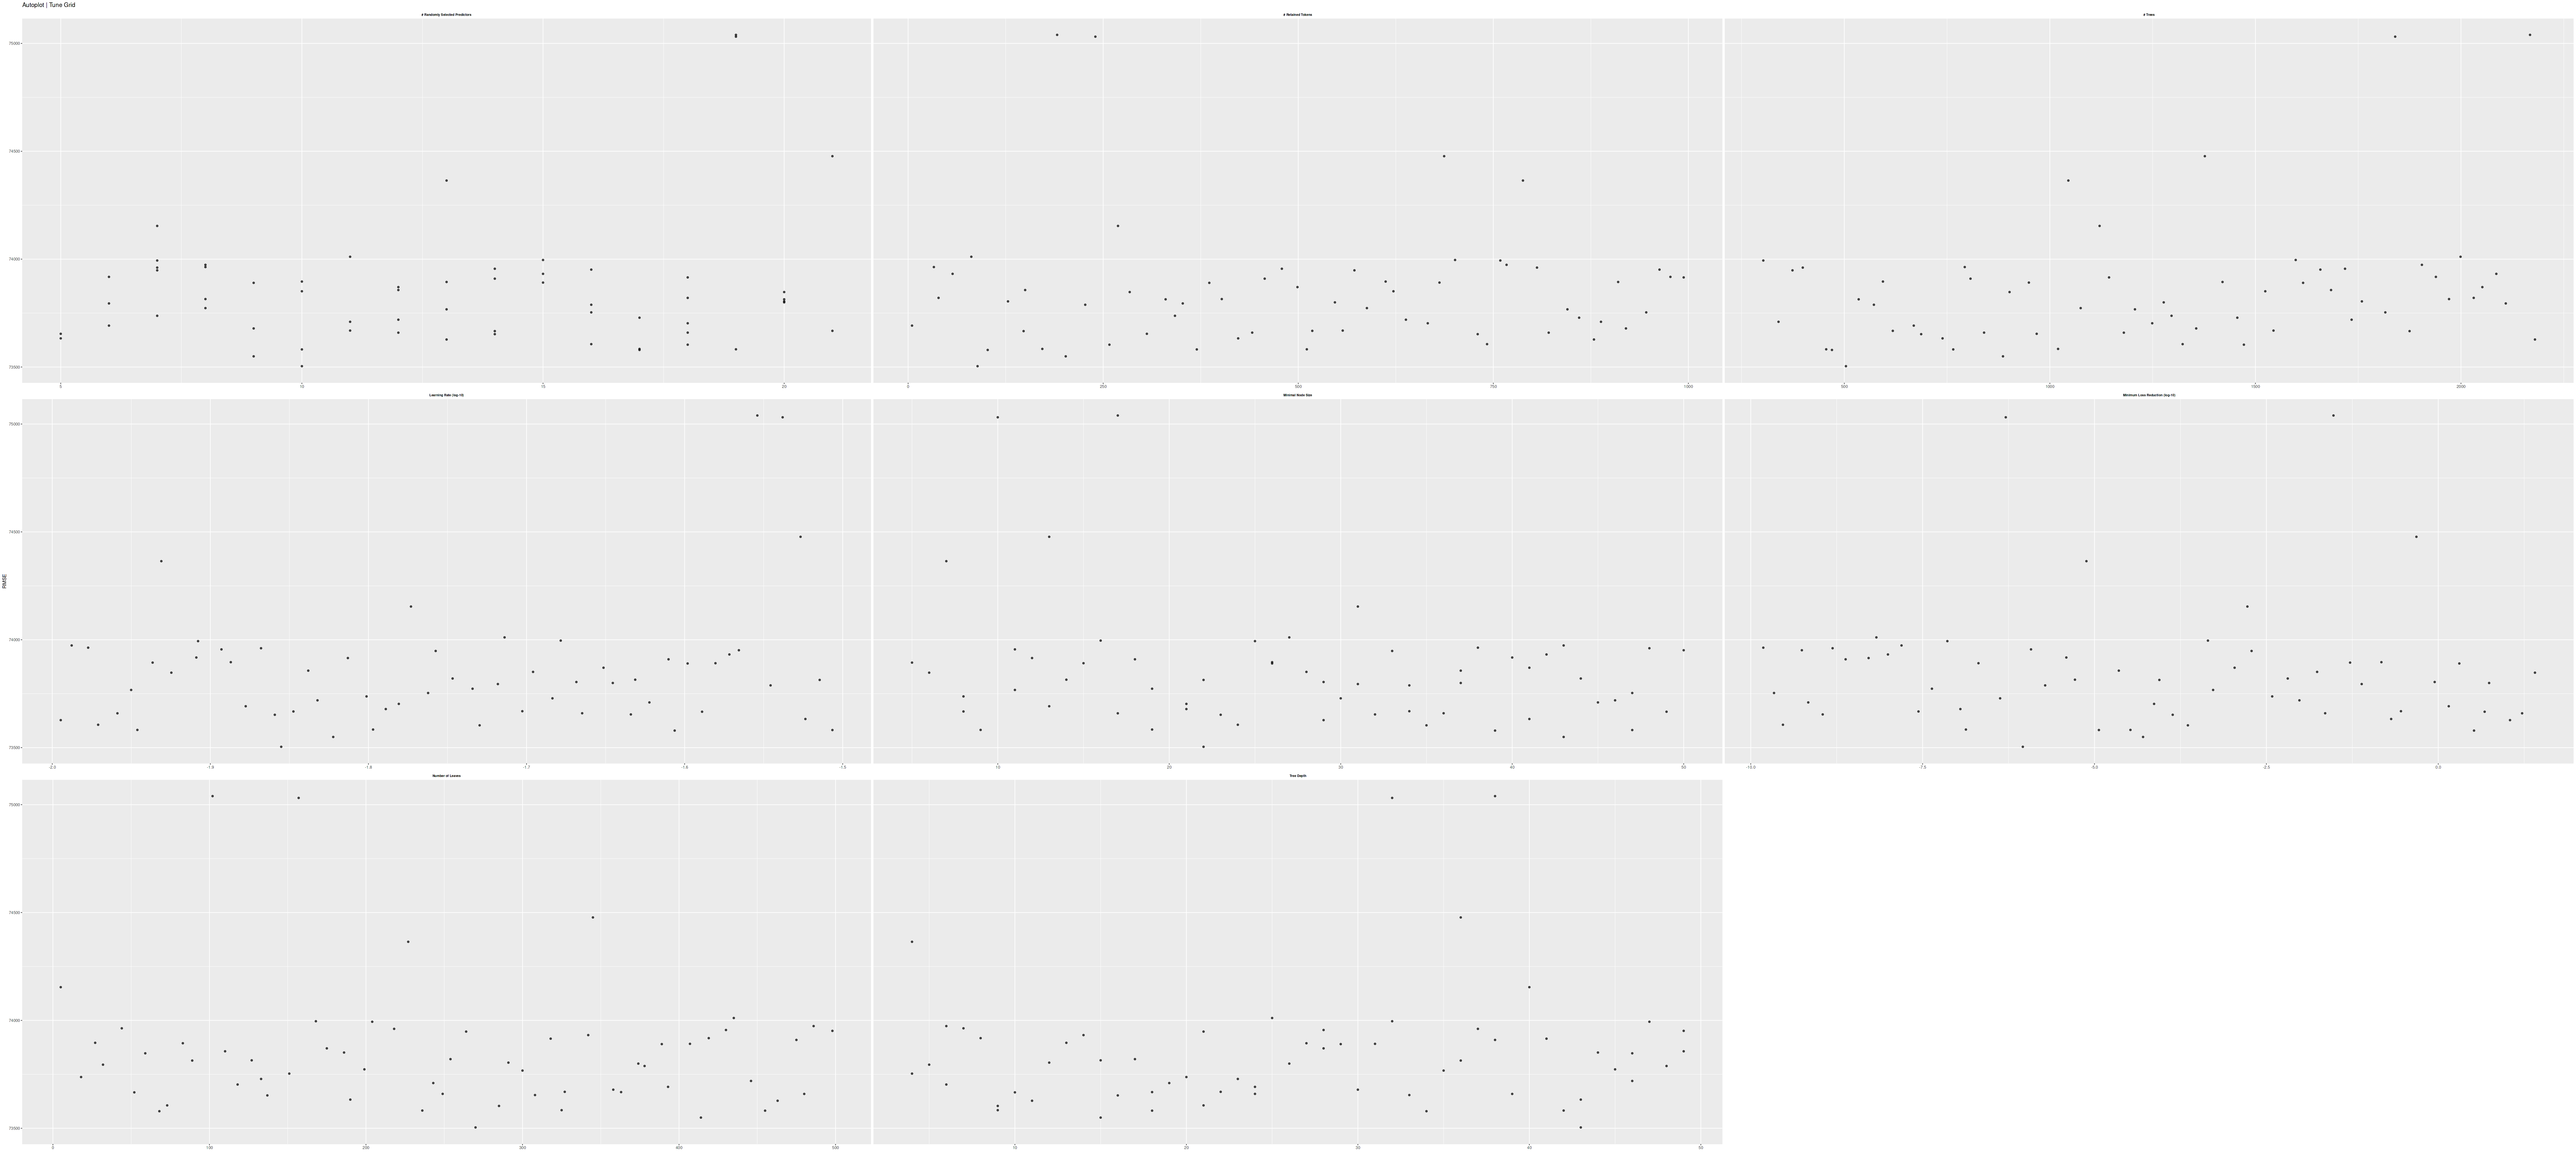

In [35]:
autoplot(lgbm_res) +
  theme(
    legend.position = "top",
    strip.background = element_rect(fill = "white"),
    strip.background.x = element_rect(colour = "white"),
    strip.background.y = element_rect(colour = "white"),
    strip.text = element_text(
      color = "black",
      face = "bold",
      size = 7
    )
  ) +
  labs(title = "Autoplot | Tune Grid",
    y = "RMSE")

In [36]:
show_best(lgbm_res, metric = "rmse") %>%
  kbl() %>%
  kable_classic(full_width = F, position = "left")

<table class=" lightable-classic" style='font-family: "Arial Narrow", "Source Sans Pro", sans-serif; width: auto !important; '>
 <thead>
  <tr>
   <th style="text-align:right;"> mtry </th>
   <th style="text-align:right;"> trees </th>
   <th style="text-align:right;"> min_n </th>
   <th style="text-align:right;"> tree_depth </th>
   <th style="text-align:right;"> learn_rate </th>
   <th style="text-align:right;"> loss_reduction </th>
   <th style="text-align:right;"> num_leaves </th>
   <th style="text-align:right;"> max_tokens </th>
   <th style="text-align:left;"> .metric </th>
   <th style="text-align:left;"> .estimator </th>
   <th style="text-align:right;"> mean </th>
   <th style="text-align:right;"> n </th>
   <th style="text-align:right;"> std_err </th>
   <th style="text-align:left;"> .config </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:right;"> 10 </td>
   <td style="text-align:right;"> 504 </td>
   <td style="text-align:right;"> 22 </td>
   <td style="text

In [37]:
final_fit <- wf %>%
  finalize_workflow(select_best(lgbm_res, metric = "rmse")) %>%
  fit(train)

In [38]:
pred <- predict(final_fit, new_data = test, type = "numeric")

In [39]:
sub<-cbind(id,pred)

In [40]:
colnames(sub)<-c("id","price")

In [41]:
write.csv(sub,"submission2.csv",quote = FALSE, row.names = FALSE)

In [42]:
head(sub)

id     price   
1 188533 19636.46
2 188534 75415.28
3 188535 49935.91
4 188536 28349.72
5 188537 28919.75
6 188538 15636.80

**ensemble　&　Blending**

In [43]:
t1 <- read.csv("/kaggle/input/sub4-9-1/submission4_9_1.csv")
#t2 <- read.csv("/kaggle/input/sub12345/submission12345.csv")

In [44]:
t1<-t1[,2]
#t2<-t2[,2]

In [45]:
abc<-(t1*5+sub[,2]*2)/7

In [46]:
abc<-as.data.frame(abc)

In [47]:
com<-cbind(id,abc)

In [48]:
colnames(com)<-c("id","price")

In [49]:
write.csv(com,"submission5.csv",quote = FALSE, row.names = FALSE)